In [1]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments,DataCollatorForLanguageModeling

from copy import deepcopy
from torch.utils.data import Dataset
import tqdm
import csv
from torch.utils.data import DataLoader


import pandas as pd
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

from sklearn.utils import compute_class_weight

import evaluate

accuracy = evaluate.load("accuracy")
balanced_accuracy = evaluate.load("hyperml/balanced_accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
roc_auc = evaluate.load("roc_auc")

import numpy as np
def compute_metrics(eval_pred):
    # print(eval_pred)
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"balanced_accuracy":round(balanced_accuracy.compute(predictions=predictions, references=labels)['balanced_accuracy'],2),"precision":round(precision.compute(predictions=predictions, references=labels)['precision'],2),"recall":round(recall.compute(predictions=predictions, references=labels)['recall'],2),"f1":round(f1.compute(predictions=predictions, references=labels)['f1'],2)} #,round(roc_auc.compute(predictions=predictions, references=labels)['roc_auc'],2))

import matplotlib.pyplot as plt

In [2]:
from transformers import AutoTokenizer, AutoConfig, AutoModel, DistilBertForSequenceClassification

import torch

class CustomModel(torch.nn.Module):
    """
    This takes a transformer backbone and puts a slightly-modified classification head on top.
    
    """

    def __init__(self, num_extra_dims, num_labels=2):
        # num_extra_dims corresponds to the number of extra dimensions of numerical/categorical data

        super().__init__()
        
        self.config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
        self.transformer=AutoModel.from_pretrained("distilbert-base-uncased",config=self.config)
        # self.transformer = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
        self.tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        num_hidden_size = self.transformer.config.hidden_size # May be different depending on which model you use. Common sizes are 768 and 1024. Look in the config.json file 

        self.linear_layer_1 = torch.nn.Linear(num_hidden_size+num_extra_dims, 32)
        # Output size is 1 since this is a binary classification problem
        self.linear_layer_2 = torch.nn.Linear(32, 16)
        self.linear_layer_output = torch.nn.Linear(16, 2)
        self.relu = torch.nn.LeakyReLU(0.6)
        self.dropout_1 = torch.nn.Dropout(0.5)


    def forward(self, input_ids, extra_features, attention_mask=None, labels=None):
        """
        extra_features should be of shape [batch_size, dim] 
        where dim is the number of additional numerical/categorical dimensions
        """

        hidden_states = self.transformer(input_ids=input_ids, attention_mask=attention_mask) # [batch size, sequence length, hidden size]

        cls_embeds = hidden_states.last_hidden_state[:, 0, :] # [batch size, hidden size]

        concat = torch.cat((cls_embeds, extra_features), dim=-1) # [batch size, hidden size+num extra dims]

        output_1 = self.relu(self.linear_layer_1(concat)) # [batch size, num labels]
        output_2 = self.relu(self.linear_layer_2(output_1))
        final_output = self.linear_layer_output(output_2)

        return final_output

In [3]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
print(device)

cuda


In [4]:
class TwitterDataset(Dataset):
    """
    Implement TwitterDataset in Pytorch
    """
    def __init__(self, path, tokenizer, device, name):
        
        self.label_to_id = {"no_answer": 0, "answer": 1}
        self.id_to_label = {0: "no_answer", 1: "answer"}
        
        self.tokenizer = tokenizer
        self.pad_id=tokenizer.encode(tokenizer.pad_token,add_special_tokens=False)[0]
        self.text_samples = []
        self.labels = []
        self.samples=[]
        dropped=0
        
        print("Building Twitter Dataset...",end='')
        
        with open(path, "r") as read_obj:
            reader = csv.reader(read_obj)
            for ind,sample in enumerate(reader):
                if ind!=0:
                    # print(sample[4])
                    try:
                        self.text_samples.append(sample[4])
                        # tokens=tokenizer(sample[4],return_tensors="pt")
                        # tokens['input_ids']=tokens['input_ids'].squeeze(0)
                        # tokens['attention_mask']=tokens['attention_mask'].squeeze(0)
                        label=torch.tensor(int(sample[8]))
                        tokenized=tokenizer(sample[4],return_tensors="pt",padding=True,truncation=True)
                        # print(sample[4])
                        dictionary={"text": sample[4], "label": int(sample[8])}
                        tokenized['input_ids']=tokenized['input_ids'].squeeze(0).to(device)
                        tokenized['attention_mask']=tokenized['attention_mask'].squeeze(0).to(device)
                        
                        if name in ['airlines','banks']:
                            rate_following=(float(sample[-16])+0.00001)/(float(sample[-17])+0.00001)
                            num_mentions = float(sample[-9])
                            num_links = float(sample[-8])
                            num_full_words =float(sample[-7])
                            num_tokenized_words=float(sample[-6])
                            num_hashtags=float(sample[-5])
                            num_NGO_mentions=float(sample[-4])
                            num_exclamation=float(sample[-3])
                            num_question=float(sample[-2])
                            sentiment=1 if sample[-1]=='positive' else (-1 if sample[-1]=='negative' else 0)
                            # self.features.append([rate_following,num_mentions,num_links,num_full_words,num_tokenized_words,num_hashtags,num_NGO_mentions,num_exclamation,num_question,sentiment])
                            dictionary['features']=[rate_following,num_mentions,num_links,num_full_words,num_tokenized_words,num_hashtags,num_NGO_mentions,num_exclamation,num_question,sentiment]
                        elif name in ['icrc','other_ngo']:
                            rate_following=(float(sample[-17])+0.00001)/(float(sample[-18])+0.00001)
                            num_mentions = float(sample[-10])
                            num_links = float(sample[-9])
                            num_full_words =float(sample[-8])
                            num_tokenized_words=float(sample[-7])
                            num_hashtags=float(sample[-6])
                            num_NGO_mentions=float(sample[-5])
                            num_exclamation=float(sample[-4])
                            num_question=float(sample[-3])
                            # has_question=float(sample[-2])
                            sentiment=1 if sample[-1]=='positive' else (-1 if sample[-1]=='negative' else 0)
                            # self.features.append([rate_following,num_mentions,num_links,num_full_words,num_tokenized_words,num_hashtags,num_NGO_mentions,num_exclamation,num_question, sentiment])
                            dictionary['features']=[rate_following,num_mentions,num_links,num_full_words,num_tokenized_words,num_hashtags,num_NGO_mentions,num_exclamation,num_question,sentiment]
                        else:
                            rate_following=(float(sample[-20])+0.00001)/(float(sample[-21])+0.00001)
                            num_mentions = float(sample[-13])
                            num_links = float(sample[-12])
                            num_full_words =float(sample[-11])
                            num_tokenized_words=float(sample[-10])
                            num_hashtags=float(sample[-9])
                            num_NGO_mentions=float(sample[-8])
                            num_exclamation=float(sample[-7])
                            num_question=float(sample[-6])
                            # has_question=float(sample[-2])
                            sentiment=1 if sample[-4]=='positive' else (-1 if sample[-4]=='negative' else 0)
                            # self.features.append([rate_following,num_mentions,num_links,num_full_words,num_tokenized_words,num_hashtags,num_NGO_mentions,num_exclamation,num_question,sentiment])
                            dictionary['features']=[rate_following,num_mentions,num_links,num_full_words,num_tokenized_words,num_hashtags,num_NGO_mentions,num_exclamation,num_question,sentiment]
                        
                        for key in tokenized.keys():
                            dictionary[key]=tokenized[key]
                        self.samples.append(dictionary)
                    except:
                        dropped+=1
                        continue
                    
        print(f"Dropped out {dropped} samples")

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return deepcopy(self.samples[index])
    
    
    
    def collate_fn(self, batch):
        # try:
            batch_text = [sample['text'] for sample in batch]
            batch_ids=self.tokenizer(batch_text,return_tensors="pt",padding=True).to(device) #for sample in batch_padded]
            
            tensor_batch_ids = batch_ids #torch.tensor(batch_ids)
            
            batch_labels = [sample['label'] for sample in batch]
            tensor_labels = torch.tensor(batch_labels,device=device).long()
            
            # batch_labels = [sample['label'] for sample in batch]
            # tensor_labels = torch.tensor(batch_labels,device=device).long()
            
            batch_features=[sample['features'] for sample in batch]
            extra_features=torch.tensor(batch_features,device=device).float()
            # extra_features=torch.tensor(batch_features).float()
            
            return tensor_batch_ids, tensor_labels, extra_features
        # except:
            # print(batch)
    

In [5]:
def training(name,num_epochs):
    run_name = f"combined-nd-well-answering-{name}"

    model = CustomModel(10)
    model=model.to(device)
    
    train_data=TwitterDataset(f"./data/train_wa_{name}.csv",model.tokenizer,device,name)
    test_data=TwitterDataset(f"./data/eval_wa_{name}.csv",model.tokenizer,device,name)
    
    labels=[]
    for i in train_data:
        labels.append(i['label'])
    # for i in test_data:
    #     labels.append(i['label'])
    
    class_weights=compute_class_weight('balanced',classes=np.unique(labels),y=np.array(labels))
    class_weights=torch.tensor(class_weights,dtype=torch.float,device=device)
    
    class CustomTrainer(Trainer):
        
        def compute_loss(self, model, inputs, return_outputs=False):
            # print(inputs)
            # print(inputs)
            labels = inputs[1]
            # forward pass
            input_ids=inputs[0].get("input_ids")
            attention_mask=inputs[0].get("attention_mask")
            extra_features=inputs[2]
            logits = model(input_ids,extra_features,attention_mask)
            # logits = outputs.get("logits")
            # # compute custom loss (suppose one has 3 labels with different weights)
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights,reduction='mean') #weight=torch.tensor([1.0, 2.0, 3.0])
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
            return (loss, logits) if return_outputs else loss
        
        def prediction_step(self,model,inputs,prediction_loss_only=None,ignore_keys=None):
            
            # labels may be popped when computing the loss (label smoothing for instance) so we grab them first.
            labels = inputs[1]
            # forward pass
            input_ids=inputs[0].get("input_ids")
            attention_mask=inputs[0].get("attention_mask")
            extra_features=inputs[2]

            with torch.no_grad():
                loss, logits = self.compute_loss(model, inputs, return_outputs=True)
                loss = loss.mean().detach()

            return (loss, logits, labels)
        
    training_args = TrainingArguments(
                    output_dir=f"models/{run_name}",
                    num_train_epochs=num_epochs,
                    evaluation_strategy = "epoch",
                    logging_steps=200,
                    per_device_train_batch_size=8,
                    learning_rate=0.000005,
                    remove_unused_columns=False,
                    dataloader_pin_memory= False,
                    weight_decay=0.01)
    
    trainer = CustomTrainer(model=model,
                    args=training_args,
                    train_dataset=train_data,
                    eval_dataset=test_data,
                    data_collator=train_data.collate_fn,
                    compute_metrics=compute_metrics
                    )
    
    return trainer

In [12]:
def plot_save_results(trainer,name,top=2):
    train_epoch=[]
    train_loss=[]

    eval_epoch=[]
    eval_loss=[]
    eval_acc=[]
    eval_f1=[]
    for i in trainer.state.log_history:
        try:
            if 'eval_loss' in i.keys():
                eval_loss.append(i['eval_loss'])
                eval_epoch.append(i['epoch'])
                eval_acc.append(i['eval_balanced_accuracy'])
                eval_f1.append(i['eval_f1'])
            else:
                train_loss.append(i['loss'])
                train_epoch.append(i['epoch'])
        except:
            pass
    
    f=open("combined_nd/"+name+'.txt','a')
    f.write(str(trainer.state.log_history))
    f.close()

    plt.scatter(train_epoch,train_loss,s=10)
    plt.ylim([0,top])
    plt.plot(eval_epoch,eval_loss,'ro-.')
    plt.plot(eval_epoch,eval_acc,'go--')
    plt.plot(eval_epoch,eval_f1,'mo:')
    plt.legend(["train_loss","eval_loss","eval_balanced_accuracy","eval_f1"])
    plt.xlabel("#epoch")
    plt.ylabel("loss")
    plt.title(name)
    None

In [7]:
def evaluation(trainer,dataset_name, eval_data,device):
    # this function should be called in the train loop to monitor the performance in validation set while training.
    
    trainer.model.eval()
    
    with torch.no_grad():
        epoch_loss=0
        predictions=[]
        targets=[]
        for data in tqdm.tqdm(eval_data,desc="Testing"):
            # YOUR CODE HERE
            loss=0
            # print(data)
            
            # forward pass
            model_loss,out=trainer.compute_loss(trainer.model, data, return_outputs=True)
            
            # print(out)
            labels = data[1]
            
            targets.extend(labels.tolist())
            predictions.extend(out.argmax(dim=-1).tolist())
            loss+=model_loss
                
            epoch_loss+=loss.item()/len(data)


        print("Evaluation for dataset "+dataset_name)
        ba=balanced_accuracy_score(targets, predictions)
        pr=precision_score(targets, predictions)
        rec=recall_score(targets, predictions)
        f1=f1_score(targets, predictions)
        print(f"Test model loss={epoch_loss / len(eval_data)}")
        print(f"Balanced_accuracy: {ba}")
        print(f"Precision: {pr}")
        print(f"Recall: {rec}")
        print(f"F1: {f1}")
        try:
            print(f"Roc_auc: {roc_auc_score(targets, predictions)}")
        except:
            print("Impossible to define ROC_AUC - only one class presents!")
    print(f"Number of ones in predictions: {sum(predictions)}")
    print(f"Number of predictions: {len(predictions)}\n")
    return predictions,targets,ba,pr,rec,f1

In [8]:
def evaluate_all_datasets(trainer):
    well_answering=TwitterDataset(f"./data/test_wa_{name}.csv",trainer.model.tokenizer,device,name)
    well_answering_data_loader=DataLoader(well_answering,batch_size=10,shuffle=False,collate_fn=well_answering.collate_fn)
    wa=evaluation(trainer,"well_answering",well_answering_data_loader,device)
    
    wa_only_ones=TwitterDataset(f"./data/oo_wa_{name}.csv",trainer.model.tokenizer,device,name)
    wa_only_ones_data_loader=DataLoader(wa_only_ones,batch_size=10,shuffle=False,collate_fn=wa_only_ones.collate_fn)
    wa_oo=evaluation(trainer,"well_answering only ones",wa_only_ones_data_loader,device)
    
    wa_only_zeros=TwitterDataset(f"./data/oz_wa_{name}.csv",trainer.model.tokenizer,device,name)
    wa_only_zeros_data_loader=DataLoader(wa_only_zeros,batch_size=10,shuffle=False,collate_fn=wa_only_zeros.collate_fn)
    wa_oz=evaluation(trainer,"well_answering only zeros",wa_only_zeros_data_loader,device)
    
    low_answering=TwitterDataset(f"./data/la_10k_{name}.csv",trainer.model.tokenizer,device,name)
    low_answering_data_loader=DataLoader(low_answering,batch_size=10,shuffle=False,collate_fn=low_answering.collate_fn)
    la=evaluation(trainer,"low_answering",low_answering_data_loader,device)

    only_ones=TwitterDataset(f"./data/oo_{name}.csv",trainer.model.tokenizer,device,name)
    only_ones_data_loader=DataLoader(only_ones,batch_size=10,shuffle=False,collate_fn=only_ones.collate_fn)
    oo=evaluation(trainer,"low_answering only ones",only_ones_data_loader,device)
    
    only_zeros=TwitterDataset(f"./data/oz_10k_{name}.csv",trainer.model.tokenizer,device,name)
    only_zeros_data_loader=DataLoader(only_zeros,batch_size=10,shuffle=False,collate_fn=only_zeros.collate_fn)
    oz=evaluation(trainer,"low_answering only zeros",only_zeros_data_loader,device)
    
    
    metrics=["balanced_accuracy","precision","recall","f1"]
    fig, ax = plt.subplots()
    ax.bar(np.arange(4),[wa[2],wa[3],wa[4],wa[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.15,[wa_oo[2],wa_oo[3],wa_oo[4],wa_oo[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.3,[wa_oz[2],wa_oz[3],wa_oz[4],wa_oz[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.45,[la[2],la[3],la[4],la[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.60,[oo[2],oo[3],oo[4],oo[5]],width=0.15,align='edge')
    ax.bar(np.arange(4)+0.75,[oz[2],oz[3],oz[4],oz[5]],width=0.15,align='edge')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [metrics[ind//2-1] if (ind%2==0) and (ind!=len(labels)-1) and (ind!=0) else '' for ind,label in enumerate(labels) ]
    ax.set_xticklabels(labels)
    # plt.plot(metrics, [wa[2],wa[3],wa[4],wa[5]],'1')
    # plt.plot(metrics,[wa_oo[2],wa_oo[3],wa_oo[4],wa_oo[5]],'2')
    # plt.plot(metrics,[wa_oz[2],wa_oz[3],wa_oz[4],wa_oz[5]],'3')
    # plt.plot(metrics,[la[2],la[3],la[4],la[5]],'4')
    # plt.plot(metrics,[oo[2],oo[3],oo[4],oo[5]],'8')
    # plt.plot(metrics,[oz[2],oz[3],oz[4],oz[5]],'s')
    ax.legend(["wa","wa_oo","wa_oz","la","la_oo","la_oz"])
    plt.xlabel("metrics")
    plt.ylabel("value")
    plt.title(name)
    
    return wa[0:2],wa_oo[:2],wa_oz[:2],la[:2],oo[:2],oz[:2]

### NGOs

In [9]:
name="ngos"

In [10]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Building Twitter Dataset...Dropped out 353 samples
Building Twitter Dataset...Dropped out 73 samples


In [11]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/40770 [00:00<?, ?it/s]

{'loss': 172.9473, 'learning_rate': 4.9754721609026244e-06, 'epoch': 0.05}
{'loss': 91.2087, 'learning_rate': 4.950944321805249e-06, 'epoch': 0.1}
{'loss': 107.8964, 'learning_rate': 4.926416482707873e-06, 'epoch': 0.15}
{'loss': 71.697, 'learning_rate': 4.901888643610498e-06, 'epoch': 0.2}
{'loss': 76.6478, 'learning_rate': 4.877360804513123e-06, 'epoch': 0.25}
{'loss': 76.1126, 'learning_rate': 4.852832965415747e-06, 'epoch': 0.29}
{'loss': 15.1379, 'learning_rate': 4.828305126318372e-06, 'epoch': 0.34}
{'loss': 6.1402, 'learning_rate': 4.803777287220997e-06, 'epoch': 0.39}
{'loss': 2.5275, 'learning_rate': 4.779249448123621e-06, 'epoch': 0.44}
{'loss': 1.08, 'learning_rate': 4.754721609026245e-06, 'epoch': 0.49}
{'loss': 0.7512, 'learning_rate': 4.73019376992887e-06, 'epoch': 0.54}
{'loss': 0.7432, 'learning_rate': 4.705665930831494e-06, 'epoch': 0.59}
{'loss': 3.3279, 'learning_rate': 4.6811380917341185e-06, 'epoch': 0.64}
{'loss': 2.8137, 'learning_rate': 4.6566102526367426e-06, '

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 1.206368327140808, 'eval_balanced_accuracy': 0.64, 'eval_precision': 0.93, 'eval_recall': 0.28, 'eval_f1': 0.43, 'eval_runtime': 10.8702, 'eval_samples_per_second': 561.996, 'eval_steps_per_second': 70.284, 'epoch': 1.0}
{'loss': 1.1438, 'learning_rate': 4.484915378955114e-06, 'epoch': 1.03}
{'loss': 1.0151, 'learning_rate': 4.460387539857739e-06, 'epoch': 1.08}
{'loss': 2.8981, 'learning_rate': 4.435859700760363e-06, 'epoch': 1.13}
{'loss': 1.0935, 'learning_rate': 4.411331861662988e-06, 'epoch': 1.18}
{'loss': 1.4399, 'learning_rate': 4.386804022565612e-06, 'epoch': 1.23}
{'loss': 0.735, 'learning_rate': 4.362276183468237e-06, 'epoch': 1.28}
{'loss': 0.6992, 'learning_rate': 4.3377483443708615e-06, 'epoch': 1.32}
{'loss': 0.6855, 'learning_rate': 4.313220505273486e-06, 'epoch': 1.37}
{'loss': 0.8983, 'learning_rate': 4.28869266617611e-06, 'epoch': 1.42}
{'loss': 0.841, 'learning_rate': 4.2641648270787344e-06, 'epoch': 1.47}
{'loss': 0.8927, 'learning_rate': 4.2396369879

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 1.4685581922531128, 'eval_balanced_accuracy': 0.67, 'eval_precision': 0.6, 'eval_recall': 0.35, 'eval_f1': 0.44, 'eval_runtime': 10.453, 'eval_samples_per_second': 584.425, 'eval_steps_per_second': 73.089, 'epoch': 2.0}
{'loss': 1.2196, 'learning_rate': 3.994358597007604e-06, 'epoch': 2.01}
{'loss': 1.3467, 'learning_rate': 3.9698307579102286e-06, 'epoch': 2.06}
{'loss': 0.8301, 'learning_rate': 3.9453029188128526e-06, 'epoch': 2.11}
{'loss': 1.1858, 'learning_rate': 3.9207750797154774e-06, 'epoch': 2.16}
{'loss': 0.8395, 'learning_rate': 3.8962472406181014e-06, 'epoch': 2.21}
{'loss': 0.9628, 'learning_rate': 3.871719401520726e-06, 'epoch': 2.26}
{'loss': 1.0665, 'learning_rate': 3.847191562423351e-06, 'epoch': 2.31}
{'loss': 0.8585, 'learning_rate': 3.822663723325975e-06, 'epoch': 2.35}
{'loss': 1.2153, 'learning_rate': 3.7981358842285996e-06, 'epoch': 2.4}
{'loss': 0.6631, 'learning_rate': 3.773608045131224e-06, 'epoch': 2.45}
{'loss': 1.1766, 'learning_rate': 3.749080

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 1.2895973920822144, 'eval_balanced_accuracy': 0.68, 'eval_precision': 0.93, 'eval_recall': 0.36, 'eval_f1': 0.52, 'eval_runtime': 10.594, 'eval_samples_per_second': 576.647, 'eval_steps_per_second': 72.116, 'epoch': 3.0}
{'loss': 1.9334, 'learning_rate': 3.479273975962718e-06, 'epoch': 3.04}
{'loss': 0.886, 'learning_rate': 3.454746136865342e-06, 'epoch': 3.09}
{'loss': 1.148, 'learning_rate': 3.430218297767967e-06, 'epoch': 3.14}
{'loss': 0.8541, 'learning_rate': 3.4056904586705915e-06, 'epoch': 3.19}
{'loss': 0.8956, 'learning_rate': 3.381162619573216e-06, 'epoch': 3.24}
{'loss': 1.2651, 'learning_rate': 3.3566347804758404e-06, 'epoch': 3.29}
{'loss': 2.4344, 'learning_rate': 3.3321069413784644e-06, 'epoch': 3.34}
{'loss': 1.0483, 'learning_rate': 3.3075791022810893e-06, 'epoch': 3.38}
{'loss': 0.685, 'learning_rate': 3.2830512631837137e-06, 'epoch': 3.43}
{'loss': 2.4754, 'learning_rate': 3.2585234240863386e-06, 'epoch': 3.48}
{'loss': 0.8198, 'learning_rate': 3.233995

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 0.6643683910369873, 'eval_balanced_accuracy': 0.76, 'eval_precision': 0.88, 'eval_recall': 0.52, 'eval_f1': 0.65, 'eval_runtime': 10.6263, 'eval_samples_per_second': 574.896, 'eval_steps_per_second': 71.897, 'epoch': 4.0}
{'loss': 0.808, 'learning_rate': 2.988717194015208e-06, 'epoch': 4.02}
{'loss': 1.0626, 'learning_rate': 2.964189354917832e-06, 'epoch': 4.07}
{'loss': 0.6393, 'learning_rate': 2.9396615158204567e-06, 'epoch': 4.12}
{'loss': 0.5401, 'learning_rate': 2.9151336767230807e-06, 'epoch': 4.17}
{'loss': 1.2889, 'learning_rate': 2.8906058376257056e-06, 'epoch': 4.22}
{'loss': 1.5206, 'learning_rate': 2.86607799852833e-06, 'epoch': 4.27}
{'loss': 1.9207, 'learning_rate': 2.841550159430954e-06, 'epoch': 4.32}
{'loss': 0.4883, 'learning_rate': 2.817022320333579e-06, 'epoch': 4.37}
{'loss': 1.5475, 'learning_rate': 2.7924944812362033e-06, 'epoch': 4.42}
{'loss': 0.8053, 'learning_rate': 2.7679666421388278e-06, 'epoch': 4.46}
{'loss': 2.6318, 'learning_rate': 2.74343

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 0.6296812295913696, 'eval_balanced_accuracy': 0.79, 'eval_precision': 0.9, 'eval_recall': 0.59, 'eval_f1': 0.72, 'eval_runtime': 10.5925, 'eval_samples_per_second': 576.729, 'eval_steps_per_second': 72.127, 'epoch': 5.0}
{'loss': 0.816, 'learning_rate': 2.498160412067697e-06, 'epoch': 5.0}
{'loss': 0.5779, 'learning_rate': 2.4736325729703215e-06, 'epoch': 5.05}
{'loss': 1.0152, 'learning_rate': 2.449104733872946e-06, 'epoch': 5.1}
{'loss': 0.4827, 'learning_rate': 2.4245768947755703e-06, 'epoch': 5.15}
{'loss': 2.9243, 'learning_rate': 2.4000490556781948e-06, 'epoch': 5.2}
{'loss': 0.9369, 'learning_rate': 2.3755212165808196e-06, 'epoch': 5.25}
{'loss': 1.0338, 'learning_rate': 2.350993377483444e-06, 'epoch': 5.3}
{'loss': 0.6348, 'learning_rate': 2.3264655383860685e-06, 'epoch': 5.35}
{'loss': 0.9137, 'learning_rate': 2.301937699288693e-06, 'epoch': 5.4}
{'loss': 1.1478, 'learning_rate': 2.2774098601913174e-06, 'epoch': 5.45}
{'loss': 1.4638, 'learning_rate': 2.252882021

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 0.9419264793395996, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.94, 'eval_recall': 0.71, 'eval_f1': 0.81, 'eval_runtime': 10.5546, 'eval_samples_per_second': 578.801, 'eval_steps_per_second': 72.386, 'epoch': 6.0}
{'loss': 1.7737, 'learning_rate': 1.983075791022811e-06, 'epoch': 6.03}
{'loss': 0.6691, 'learning_rate': 1.9585479519254355e-06, 'epoch': 6.08}
{'loss': 0.4072, 'learning_rate': 1.93402011282806e-06, 'epoch': 6.13}
{'loss': 1.1617, 'learning_rate': 1.9094922737306844e-06, 'epoch': 6.18}
{'loss': 0.7927, 'learning_rate': 1.884964434633309e-06, 'epoch': 6.23}
{'loss': 2.8727, 'learning_rate': 1.8604365955359335e-06, 'epoch': 6.28}
{'loss': 0.4588, 'learning_rate': 1.835908756438558e-06, 'epoch': 6.33}
{'loss': 0.6417, 'learning_rate': 1.8113809173411822e-06, 'epoch': 6.38}
{'loss': 0.5945, 'learning_rate': 1.7868530782438068e-06, 'epoch': 6.43}
{'loss': 0.9327, 'learning_rate': 1.7623252391464313e-06, 'epoch': 6.48}
{'loss': 0.4391, 'learning_rate': 1.737

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 0.7860576510429382, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.98, 'eval_recall': 0.71, 'eval_f1': 0.82, 'eval_runtime': 10.5604, 'eval_samples_per_second': 578.482, 'eval_steps_per_second': 72.346, 'epoch': 7.0}
{'loss': 0.9729, 'learning_rate': 1.4925190090753005e-06, 'epoch': 7.01}
{'loss': 0.4034, 'learning_rate': 1.4679911699779252e-06, 'epoch': 7.06}
{'loss': 2.3301, 'learning_rate': 1.4434633308805496e-06, 'epoch': 7.11}
{'loss': 0.6576, 'learning_rate': 1.418935491783174e-06, 'epoch': 7.16}
{'loss': 0.7867, 'learning_rate': 1.3944076526857985e-06, 'epoch': 7.21}
{'loss': 0.6642, 'learning_rate': 1.3698798135884231e-06, 'epoch': 7.26}
{'loss': 0.7754, 'learning_rate': 1.3453519744910474e-06, 'epoch': 7.31}
{'loss': 0.554, 'learning_rate': 1.3208241353936718e-06, 'epoch': 7.36}
{'loss': 0.5742, 'learning_rate': 1.2962962962962962e-06, 'epoch': 7.41}
{'loss': 0.5432, 'learning_rate': 1.271768457198921e-06, 'epoch': 7.46}
{'loss': 0.3595, 'learning_rate': 1.2

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 0.6612171530723572, 'eval_balanced_accuracy': 0.88, 'eval_precision': 0.98, 'eval_recall': 0.75, 'eval_f1': 0.85, 'eval_runtime': 10.5872, 'eval_samples_per_second': 577.015, 'eval_steps_per_second': 72.162, 'epoch': 8.0}
{'loss': 0.6123, 'learning_rate': 9.774343880304146e-07, 'epoch': 8.05}
{'loss': 0.4481, 'learning_rate': 9.529065489330391e-07, 'epoch': 8.09}
{'loss': 0.4969, 'learning_rate': 9.283787098356635e-07, 'epoch': 8.14}
{'loss': 1.7265, 'learning_rate': 9.03850870738288e-07, 'epoch': 8.19}
{'loss': 0.5901, 'learning_rate': 8.793230316409126e-07, 'epoch': 8.24}
{'loss': 0.4512, 'learning_rate': 8.54795192543537e-07, 'epoch': 8.29}
{'loss': 0.5228, 'learning_rate': 8.302673534461615e-07, 'epoch': 8.34}
{'loss': 0.5471, 'learning_rate': 8.057395143487859e-07, 'epoch': 8.39}
{'loss': 0.438, 'learning_rate': 7.812116752514104e-07, 'epoch': 8.44}
{'loss': 0.4143, 'learning_rate': 7.566838361540349e-07, 'epoch': 8.49}
{'loss': 0.506, 'learning_rate': 7.321559970566

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 0.4466888904571533, 'eval_balanced_accuracy': 0.89, 'eval_precision': 0.98, 'eval_recall': 0.78, 'eval_f1': 0.87, 'eval_runtime': 10.5394, 'eval_samples_per_second': 579.635, 'eval_steps_per_second': 72.49, 'epoch': 9.0}
{'loss': 0.2762, 'learning_rate': 4.868776060829041e-07, 'epoch': 9.03}
{'loss': 0.5705, 'learning_rate': 4.623497669855286e-07, 'epoch': 9.08}
{'loss': 0.4643, 'learning_rate': 4.3782192788815305e-07, 'epoch': 9.12}
{'loss': 0.5346, 'learning_rate': 4.1329408879077754e-07, 'epoch': 9.17}
{'loss': 0.4664, 'learning_rate': 3.887662496934021e-07, 'epoch': 9.22}
{'loss': 0.5326, 'learning_rate': 3.642384105960265e-07, 'epoch': 9.27}
{'loss': 0.528, 'learning_rate': 3.39710571498651e-07, 'epoch': 9.32}
{'loss': 0.4491, 'learning_rate': 3.1518273240127546e-07, 'epoch': 9.37}
{'loss': 0.2031, 'learning_rate': 2.9065489330389995e-07, 'epoch': 9.42}
{'loss': 0.314, 'learning_rate': 2.6612705420652444e-07, 'epoch': 9.47}
{'loss': 0.9486, 'learning_rate': 2.4159921

  0%|          | 0/764 [00:00<?, ?it/s]

{'eval_loss': 0.4304501712322235, 'eval_balanced_accuracy': 0.89, 'eval_precision': 0.99, 'eval_recall': 0.78, 'eval_f1': 0.87, 'eval_runtime': 10.4969, 'eval_samples_per_second': 581.979, 'eval_steps_per_second': 72.783, 'epoch': 10.0}
{'train_runtime': 2592.5801, 'train_samples_per_second': 125.805, 'train_steps_per_second': 15.726, 'train_loss': 3.9848197005091563, 'epoch': 10.0}


TrainOutput(global_step=40770, training_loss=3.9848197005091563, metrics={'train_runtime': 2592.5801, 'train_samples_per_second': 125.805, 'train_steps_per_second': 15.726, 'train_loss': 3.9848197005091563, 'epoch': 10.0})

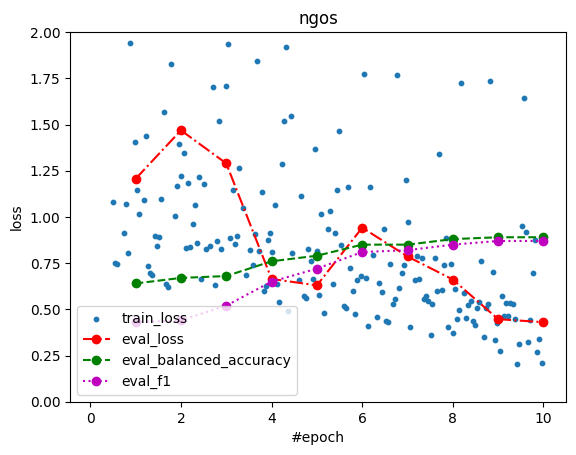

In [15]:
plot_save_results(trainer,name)

Building Twitter Dataset...Dropped out 26 samples


Testing: 100%|██████████| 204/204 [00:03<00:00, 56.87it/s]


Evaluation for dataset well_answering
Test model loss=0.16268297324740422
Balanced_accuracy: 0.9080021118222941
Precision: 0.9852941176470589
Recall: 0.8170731707317073
F1: 0.8933333333333334
Roc_auc: 0.9080021118222938
Number of ones in predictions: 136
Number of predictions: 2035

Building Twitter Dataset...Dropped out 65 samples


Testing: 100%|██████████| 333/333 [00:05<00:00, 60.14it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.6725334755028589
Balanced_accuracy: 0.7267529340956966
Precision: 1.0
Recall: 0.7267529340956966
F1: 0.841756709654932
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 2415
Number of predictions: 3323

Building Twitter Dataset...Dropped out 98 samples


Testing: 100%|██████████| 991/991 [00:16<00:00, 60.34it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.011112663351541914
Balanced_accuracy: 0.9940416077560089
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 59
Number of predictions: 9902

Building Twitter Dataset...Dropped out 54 samples


Testing: 100%|██████████| 995/995 [00:17<00:00, 56.42it/s]


Evaluation for dataset low_answering
Test model loss=0.8083548685442198
Balanced_accuracy: 0.6211802719418664
Precision: 0.02862595419847328
Recall: 0.6069364161849711
F1: 0.05467326217130955
Roc_auc: 0.6211802719418664
Number of ones in predictions: 3668
Number of predictions: 9946

Building Twitter Dataset...Dropped out 35 samples


Testing: 100%|██████████| 119/119 [00:02<00:00, 58.59it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.9171408419286987
Balanced_accuracy: 0.6210970464135022
Precision: 1.0
Recall: 0.6210970464135022
F1: 0.7662675689744924
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 736
Number of predictions: 1185

Building Twitter Dataset...Dropped out 84 samples


Testing: 100%|██████████| 992/992 [00:17<00:00, 58.18it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.04788879970418671
Balanced_accuracy: 0.9738805970149254
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 259
Number of predictions: 9916



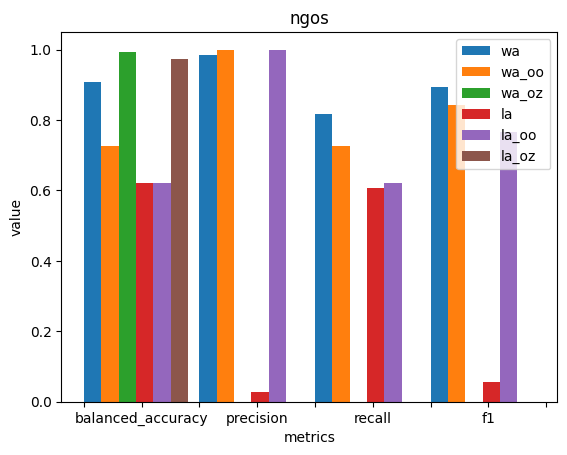

In [16]:
a=evaluate_all_datasets(trainer)

##### Generalization

In [ ]:
# model=CustomModel.from_pretrained("models/well-answering-ngos/checkpoint-41000/")
# model=model.to(device)

Building Twitter Dataset...Dropped out 4 samples


Testing: 100%|██████████| 58/58 [00:00<00:00, 60.80it/s]


Evaluation for dataset well_answering
Test model loss=0.6759935817413629
Balanced_accuracy: 0.6905175548462689
Precision: 0.28152492668621704
Recall: 0.9056603773584906
F1: 0.4295302013422819
Roc_auc: 0.6905175548462689
Number of ones in predictions: 341
Number of predictions: 573

Building Twitter Dataset...Dropped out 12 samples


Testing: 100%|██████████| 210/210 [00:03<00:00, 56.88it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.357996100461894
Balanced_accuracy: 0.8876135820181731
Precision: 1.0
Recall: 0.8876135820181731
F1: 0.9404611097035722
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1856
Number of predictions: 2091

Building Twitter Dataset...Dropped out 83 samples


Testing: 100%|██████████| 936/936 [00:16<00:00, 57.75it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=1.2910315353911577
Balanced_accuracy: 0.42099636519136197
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 5416
Number of predictions: 9354

Building Twitter Dataset...Dropped out 88 samples


Testing: 100%|██████████| 992/992 [00:17<00:00, 55.13it/s]


Evaluation for dataset low_answering
Test model loss=1.3643404749292194
Balanced_accuracy: 0.5147279740154284
Precision: 0.006324232608360327
Recall: 0.6833333333333333
F1: 0.012532477456824087
Roc_auc: 0.5147279740154284
Number of ones in predictions: 6483
Number of predictions: 9912

Building Twitter Dataset...Dropped out 0 samples


Testing: 100%|██████████| 7/7 [00:00<00:00, 90.91it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.8672265041442143
Balanced_accuracy: 0.6885245901639344
Precision: 1.0
Recall: 0.6885245901639344
F1: 0.8155339805825244
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 42
Number of predictions: 61

Building Twitter Dataset...Dropped out 90 samples


Testing: 100%|██████████| 991/991 [00:17<00:00, 57.78it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=1.373752009364774
Balanced_accuracy: 0.34712411705348134
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 6470
Number of predictions: 9910



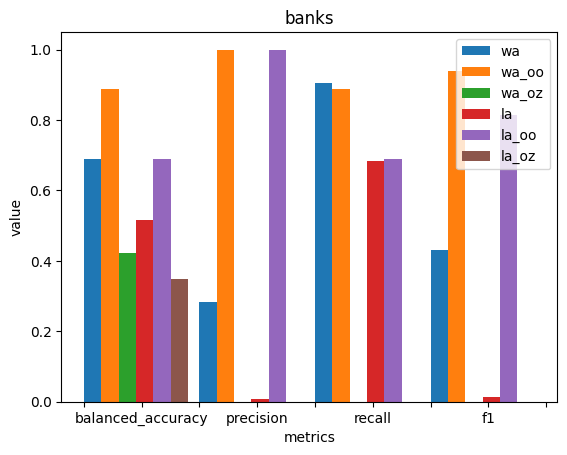

In [17]:
name="banks"
a=evaluate_all_datasets(trainer)

Building Twitter Dataset...Dropped out 2 samples


Testing: 100%|██████████| 46/46 [00:00<00:00, 59.66it/s]


Evaluation for dataset well_answering
Test model loss=0.48981688668330514
Balanced_accuracy: 0.5157170727822902
Precision: 0.4105504587155963
Recall: 0.9728260869565217
F1: 0.5774193548387097
Roc_auc: 0.5157170727822902
Number of ones in predictions: 436
Number of predictions: 457

Building Twitter Dataset...Dropped out 9 samples


Testing: 100%|██████████| 356/356 [00:05<00:00, 59.63it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.3900194248784731
Balanced_accuracy: 0.9620573355817875
Precision: 1.0
Recall: 0.9620573355817875
F1: 0.9806617963042544
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 3423
Number of predictions: 3558

Building Twitter Dataset...Dropped out 33 samples


Testing: 100%|██████████| 558/558 [00:09<00:00, 57.53it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=2.1455836008384073
Balanced_accuracy: 0.06725251076040172
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 5201
Number of predictions: 5576

Building Twitter Dataset...Dropped out 58 samples


Testing: 100%|██████████| 942/942 [00:14<00:00, 63.29it/s]


Evaluation for dataset low_answering
Test model loss=0.9312858469019708
Balanced_accuracy: 0.5072135169825693
Precision: 0.21579581553291707
Recall: 0.9810756972111554
F1: 0.3537757026129119
Roc_auc: 0.5072135169825693
Number of ones in predictions: 9129
Number of predictions: 9414

Building Twitter Dataset...Dropped out 10 samples


Testing: 100%|██████████| 201/201 [00:02<00:00, 68.84it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.2541641352119413
Balanced_accuracy: 0.9810756972111554
Precision: 1.0
Recall: 0.9810756972111554
F1: 0.9904474610356964
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1970
Number of predictions: 2008

Building Twitter Dataset...Dropped out 48 samples


Testing: 100%|██████████| 741/741 [00:11<00:00, 66.14it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=2.2675276943492957
Balanced_accuracy: 0.03335133675398326
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 7159
Number of predictions: 7406



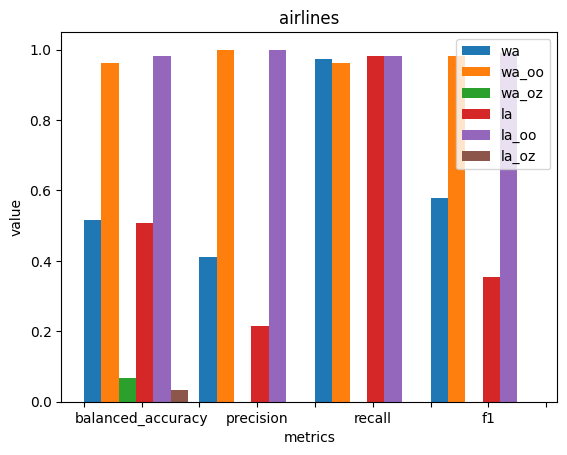

In [18]:
name="airlines"
a=evaluate_all_datasets(trainer)

### Banks

In [19]:
name="banks"

In [20]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Building Twitter Dataset...Dropped out 83 samples
Building Twitter Dataset...Dropped out 11 samples


In [21]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/11440 [00:00<?, ?it/s]

{'loss': 112.2932, 'learning_rate': 4.912587412587413e-06, 'epoch': 0.17}
{'loss': 3.4782, 'learning_rate': 4.8251748251748255e-06, 'epoch': 0.35}
{'loss': 52.311, 'learning_rate': 4.737762237762238e-06, 'epoch': 0.52}
{'loss': 36.9748, 'learning_rate': 4.650349650349651e-06, 'epoch': 0.7}
{'loss': 27.7578, 'learning_rate': 4.562937062937063e-06, 'epoch': 0.87}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 16.434947967529297, 'eval_balanced_accuracy': 0.76, 'eval_precision': 0.76, 'eval_recall': 0.57, 'eval_f1': 0.65, 'eval_runtime': 3.2659, 'eval_samples_per_second': 526.654, 'eval_steps_per_second': 65.832, 'epoch': 1.0}
{'loss': 53.6631, 'learning_rate': 4.475524475524476e-06, 'epoch': 1.05}
{'loss': 43.4968, 'learning_rate': 4.388111888111888e-06, 'epoch': 1.22}
{'loss': 10.7054, 'learning_rate': 4.300699300699301e-06, 'epoch': 1.4}
{'loss': 38.7354, 'learning_rate': 4.213286713286714e-06, 'epoch': 1.57}
{'loss': 38.4976, 'learning_rate': 4.125874125874127e-06, 'epoch': 1.75}
{'loss': 18.2375, 'learning_rate': 4.0384615384615385e-06, 'epoch': 1.92}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 9.884767532348633, 'eval_balanced_accuracy': 0.83, 'eval_precision': 0.75, 'eval_recall': 0.7, 'eval_f1': 0.73, 'eval_runtime': 3.222, 'eval_samples_per_second': 533.829, 'eval_steps_per_second': 66.729, 'epoch': 2.0}
{'loss': 42.2008, 'learning_rate': 3.951048951048951e-06, 'epoch': 2.1}
{'loss': 13.1963, 'learning_rate': 3.863636363636364e-06, 'epoch': 2.27}
{'loss': 24.8374, 'learning_rate': 3.776223776223776e-06, 'epoch': 2.45}
{'loss': 16.6368, 'learning_rate': 3.6888111888111896e-06, 'epoch': 2.62}
{'loss': 5.016, 'learning_rate': 3.6013986013986017e-06, 'epoch': 2.8}
{'loss': 7.293, 'learning_rate': 3.5139860139860142e-06, 'epoch': 2.97}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 3.859708309173584, 'eval_balanced_accuracy': 0.87, 'eval_precision': 0.74, 'eval_recall': 0.8, 'eval_f1': 0.77, 'eval_runtime': 3.111, 'eval_samples_per_second': 552.877, 'eval_steps_per_second': 69.11, 'epoch': 3.0}
{'loss': 4.9781, 'learning_rate': 3.426573426573427e-06, 'epoch': 3.15}
{'loss': 2.3305, 'learning_rate': 3.3391608391608394e-06, 'epoch': 3.32}
{'loss': 9.4031, 'learning_rate': 3.251748251748252e-06, 'epoch': 3.5}
{'loss': 2.3315, 'learning_rate': 3.164335664335665e-06, 'epoch': 3.67}
{'loss': 1.1933, 'learning_rate': 3.0769230769230774e-06, 'epoch': 3.85}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 0.3802974224090576, 'eval_balanced_accuracy': 0.87, 'eval_precision': 0.79, 'eval_recall': 0.78, 'eval_f1': 0.79, 'eval_runtime': 3.1626, 'eval_samples_per_second': 543.853, 'eval_steps_per_second': 67.982, 'epoch': 4.0}
{'loss': 0.5333, 'learning_rate': 2.98951048951049e-06, 'epoch': 4.02}
{'loss': 0.7617, 'learning_rate': 2.902097902097902e-06, 'epoch': 4.2}
{'loss': 0.8375, 'learning_rate': 2.8146853146853147e-06, 'epoch': 4.37}
{'loss': 1.2191, 'learning_rate': 2.7272727272727272e-06, 'epoch': 4.55}
{'loss': 0.8305, 'learning_rate': 2.63986013986014e-06, 'epoch': 4.72}
{'loss': 0.8014, 'learning_rate': 2.5524475524475528e-06, 'epoch': 4.9}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 0.38250237703323364, 'eval_balanced_accuracy': 0.9, 'eval_precision': 0.79, 'eval_recall': 0.85, 'eval_f1': 0.82, 'eval_runtime': 3.111, 'eval_samples_per_second': 552.877, 'eval_steps_per_second': 69.11, 'epoch': 5.0}
{'loss': 1.4461, 'learning_rate': 2.4650349650349653e-06, 'epoch': 5.07}
{'loss': 0.8601, 'learning_rate': 2.377622377622378e-06, 'epoch': 5.24}
{'loss': 1.1467, 'learning_rate': 2.2902097902097904e-06, 'epoch': 5.42}
{'loss': 0.8571, 'learning_rate': 2.202797202797203e-06, 'epoch': 5.59}
{'loss': 0.6532, 'learning_rate': 2.1153846153846155e-06, 'epoch': 5.77}
{'loss': 0.7435, 'learning_rate': 2.027972027972028e-06, 'epoch': 5.94}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 0.5209167003631592, 'eval_balanced_accuracy': 0.91, 'eval_precision': 0.83, 'eval_recall': 0.86, 'eval_f1': 0.84, 'eval_runtime': 3.225, 'eval_samples_per_second': 533.334, 'eval_steps_per_second': 66.667, 'epoch': 6.0}
{'loss': 1.0801, 'learning_rate': 1.9405594405594406e-06, 'epoch': 6.12}
{'loss': 0.8038, 'learning_rate': 1.8531468531468532e-06, 'epoch': 6.29}
{'loss': 1.1407, 'learning_rate': 1.7657342657342657e-06, 'epoch': 6.47}
{'loss': 0.5111, 'learning_rate': 1.6783216783216785e-06, 'epoch': 6.64}
{'loss': 0.5286, 'learning_rate': 1.590909090909091e-06, 'epoch': 6.82}
{'loss': 0.717, 'learning_rate': 1.5034965034965034e-06, 'epoch': 6.99}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 0.39678677916526794, 'eval_balanced_accuracy': 0.92, 'eval_precision': 0.84, 'eval_recall': 0.87, 'eval_f1': 0.86, 'eval_runtime': 3.081, 'eval_samples_per_second': 558.26, 'eval_steps_per_second': 69.783, 'epoch': 7.0}
{'loss': 0.8643, 'learning_rate': 1.4160839160839162e-06, 'epoch': 7.17}
{'loss': 0.6528, 'learning_rate': 1.3286713286713287e-06, 'epoch': 7.34}
{'loss': 0.8544, 'learning_rate': 1.2412587412587413e-06, 'epoch': 7.52}
{'loss': 0.7671, 'learning_rate': 1.153846153846154e-06, 'epoch': 7.69}
{'loss': 0.3633, 'learning_rate': 1.0664335664335666e-06, 'epoch': 7.87}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 0.3679986000061035, 'eval_balanced_accuracy': 0.93, 'eval_precision': 0.85, 'eval_recall': 0.9, 'eval_f1': 0.87, 'eval_runtime': 3.229, 'eval_samples_per_second': 532.672, 'eval_steps_per_second': 66.584, 'epoch': 8.0}
{'loss': 1.1778, 'learning_rate': 9.790209790209791e-07, 'epoch': 8.04}
{'loss': 0.5404, 'learning_rate': 8.916083916083917e-07, 'epoch': 8.22}
{'loss': 0.6495, 'learning_rate': 8.041958041958043e-07, 'epoch': 8.39}
{'loss': 0.6953, 'learning_rate': 7.167832167832168e-07, 'epoch': 8.57}
{'loss': 0.5577, 'learning_rate': 6.293706293706295e-07, 'epoch': 8.74}
{'loss': 0.8162, 'learning_rate': 5.41958041958042e-07, 'epoch': 8.92}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 0.3266451060771942, 'eval_balanced_accuracy': 0.94, 'eval_precision': 0.85, 'eval_recall': 0.91, 'eval_f1': 0.88, 'eval_runtime': 3.142, 'eval_samples_per_second': 547.422, 'eval_steps_per_second': 68.428, 'epoch': 9.0}
{'loss': 0.7586, 'learning_rate': 4.5454545454545457e-07, 'epoch': 9.09}
{'loss': 1.0431, 'learning_rate': 3.6713286713286713e-07, 'epoch': 9.27}
{'loss': 0.5284, 'learning_rate': 2.7972027972027973e-07, 'epoch': 9.44}
{'loss': 1.1005, 'learning_rate': 1.9230769230769234e-07, 'epoch': 9.62}
{'loss': 0.5362, 'learning_rate': 1.048951048951049e-07, 'epoch': 9.79}
{'loss': 0.514, 'learning_rate': 1.7482517482517483e-08, 'epoch': 9.97}


  0%|          | 0/215 [00:00<?, ?it/s]

{'eval_loss': 0.33009010553359985, 'eval_balanced_accuracy': 0.93, 'eval_precision': 0.86, 'eval_recall': 0.89, 'eval_f1': 0.88, 'eval_runtime': 3.292, 'eval_samples_per_second': 522.479, 'eval_steps_per_second': 65.31, 'epoch': 10.0}
{'train_runtime': 752.4617, 'train_samples_per_second': 121.588, 'train_steps_per_second': 15.203, 'train_loss': 10.376258624016822, 'epoch': 10.0}


TrainOutput(global_step=11440, training_loss=10.376258624016822, metrics={'train_runtime': 752.4617, 'train_samples_per_second': 121.588, 'train_steps_per_second': 15.203, 'train_loss': 10.376258624016822, 'epoch': 10.0})

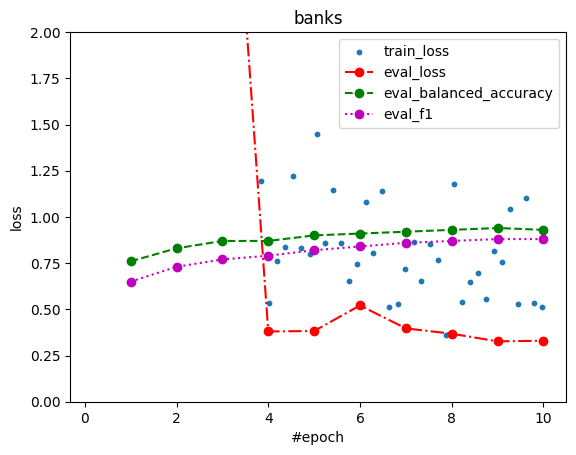

In [22]:
plot_save_results(trainer,name)

Building Twitter Dataset...Dropped out 4 samples


Testing: 100%|██████████| 58/58 [00:00<00:00, 58.83it/s]


Evaluation for dataset well_answering
Test model loss=0.14906353554848967
Balanced_accuracy: 0.9436285402609996
Precision: 0.8818181818181818
Recall: 0.9150943396226415
F1: 0.8981481481481483
Roc_auc: 0.9436285402609995
Number of ones in predictions: 110
Number of predictions: 573

Building Twitter Dataset...Dropped out 12 samples


Testing: 100%|██████████| 210/210 [00:03<00:00, 54.78it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.5068807847916137
Balanced_accuracy: 0.8321377331420373
Precision: 1.0
Recall: 0.8321377331420373
F1: 0.9083790133124511
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1740
Number of predictions: 2091

Building Twitter Dataset...Dropped out 83 samples


Testing: 100%|██████████| 936/936 [00:16<00:00, 56.56it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.04675608934924808
Balanced_accuracy: 0.9560615779345735
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 411
Number of predictions: 9354

Building Twitter Dataset...Dropped out 88 samples


Testing: 100%|██████████| 992/992 [00:18<00:00, 53.02it/s]


Evaluation for dataset low_answering
Test model loss=0.27751372969629234
Balanced_accuracy: 0.6245432399512789
Precision: 0.011990407673860911
Recall: 0.5
F1: 0.023419203747072598
Roc_auc: 0.6245432399512789
Number of ones in predictions: 2502
Number of predictions: 9912

Building Twitter Dataset...Dropped out 0 samples


Testing: 100%|██████████| 7/7 [00:00<00:00, 85.36it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.9521705479848953
Balanced_accuracy: 0.5081967213114754
Precision: 1.0
Recall: 0.5081967213114754
F1: 0.673913043478261
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 31
Number of predictions: 61

Building Twitter Dataset...Dropped out 90 samples


Testing: 100%|██████████| 991/991 [00:18<00:00, 54.68it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.26329340445212324
Balanced_accuracy: 0.7491422805247225
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 2486
Number of predictions: 9910



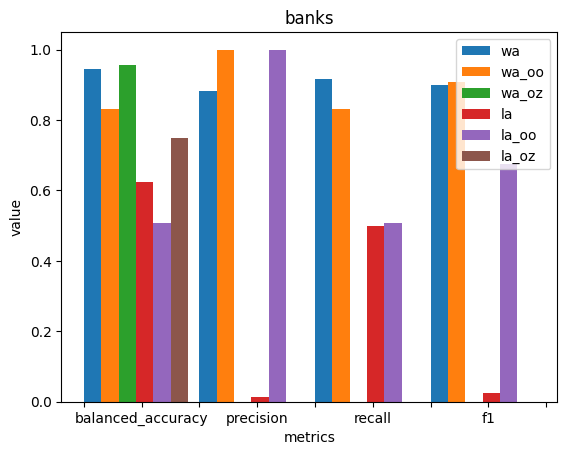

In [23]:
a=evaluate_all_datasets(trainer)

##### Generalization

In [ ]:
# model=DistilBertForSequenceClassification.from_pretrained("models/combined-well-answering-banks/checkpoint-28500/")
# model=model.to(device)

Building Twitter Dataset...Dropped out 26 samples


Testing: 100%|██████████| 204/204 [00:03<00:00, 52.19it/s]


Evaluation for dataset well_answering
Test model loss=0.8548382893691655
Balanced_accuracy: 0.5666169128286687
Precision: 0.09305210918114144
Recall: 0.9146341463414634
F1: 0.16891891891891891
Roc_auc: 0.5666169128286687
Number of ones in predictions: 1612
Number of predictions: 2035

Building Twitter Dataset...Dropped out 65 samples


Testing: 100%|██████████| 333/333 [00:06<00:00, 55.21it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.4093730795785443
Balanced_accuracy: 0.9070117363827866
Precision: 1.0
Recall: 0.9070117363827866
F1: 0.9512387565093894
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 3014
Number of predictions: 3323

Building Twitter Dataset...Dropped out 98 samples


Testing: 100%|██████████| 991/991 [00:17<00:00, 58.23it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.9802382860446768
Balanced_accuracy: 0.2292466168450818
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 7632
Number of predictions: 9902

Building Twitter Dataset...Dropped out 54 samples


Testing: 100%|██████████| 995/995 [00:18<00:00, 54.58it/s]


Evaluation for dataset low_answering
Test model loss=1.0249022914935997
Balanced_accuracy: 0.5253588836531461
Precision: 0.018425460636515914
Recall: 0.8901734104046243
F1: 0.036103622084163636
Roc_auc: 0.5253588836531461
Number of ones in predictions: 8358
Number of predictions: 9946

Building Twitter Dataset...Dropped out 35 samples


Testing: 100%|██████████| 119/119 [00:02<00:00, 57.02it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.4289175398199079
Balanced_accuracy: 0.9164556962025316
Precision: 1.0
Recall: 0.9164556962025316
F1: 0.9564068692206077
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1086
Number of predictions: 1185

Building Twitter Dataset...Dropped out 84 samples


Testing: 100%|██████████| 992/992 [00:17<00:00, 57.06it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=1.099508946168145
Balanced_accuracy: 0.1509681323114159
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 8419
Number of predictions: 9916



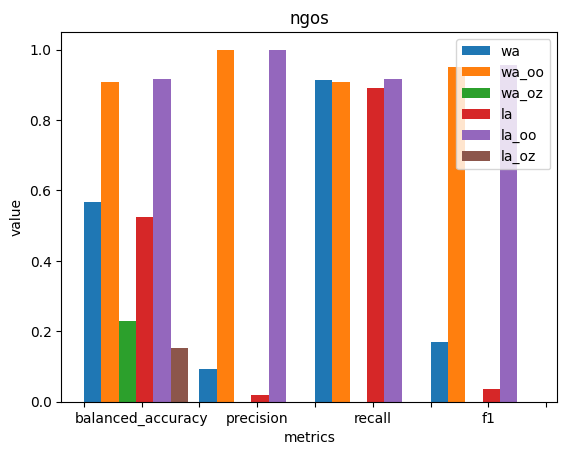

In [24]:
name="ngos"
a=evaluate_all_datasets(trainer)

Building Twitter Dataset...Dropped out 2 samples


Testing: 100%|██████████| 46/46 [00:00<00:00, 58.82it/s]


Evaluation for dataset well_answering
Test model loss=0.5598057491191919
Balanced_accuracy: 0.5203256888039497
Precision: 0.41299303944315546
Recall: 0.967391304347826
F1: 0.5788617886178862
Roc_auc: 0.5203256888039497
Number of ones in predictions: 431
Number of predictions: 457

Building Twitter Dataset...Dropped out 9 samples


Testing: 100%|██████████| 356/356 [00:06<00:00, 58.76it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.5763416985522479
Balanced_accuracy: 0.962619449128724
Precision: 1.0
Recall: 0.962619449128724
F1: 0.9809537448088214
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 3425
Number of predictions: 3558

Building Twitter Dataset...Dropped out 33 samples


Testing: 100%|██████████| 558/558 [00:10<00:00, 55.78it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=1.247455639508747
Balanced_accuracy: 0.0746054519368723
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 5160
Number of predictions: 5576

Building Twitter Dataset...Dropped out 58 samples


Testing: 100%|██████████| 942/942 [00:15<00:00, 62.19it/s]


Evaluation for dataset low_answering
Test model loss=0.8353048911119121
Balanced_accuracy: 0.5109854936182895
Precision: 0.21713653952459921
Recall: 0.9780876494023905
F1: 0.355378630236135
Roc_auc: 0.5109854936182895
Number of ones in predictions: 9045
Number of predictions: 9414

Building Twitter Dataset...Dropped out 10 samples


Testing: 100%|██████████| 201/201 [00:02<00:00, 68.07it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.3837819962606304
Balanced_accuracy: 0.9780876494023905
Precision: 1.0
Recall: 0.9780876494023905
F1: 0.9889224572004028
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1964
Number of predictions: 2008

Building Twitter Dataset...Dropped out 48 samples


Testing: 100%|██████████| 741/741 [00:11<00:00, 65.10it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=1.2624096803926834
Balanced_accuracy: 0.0438833378341885
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 7081
Number of predictions: 7406



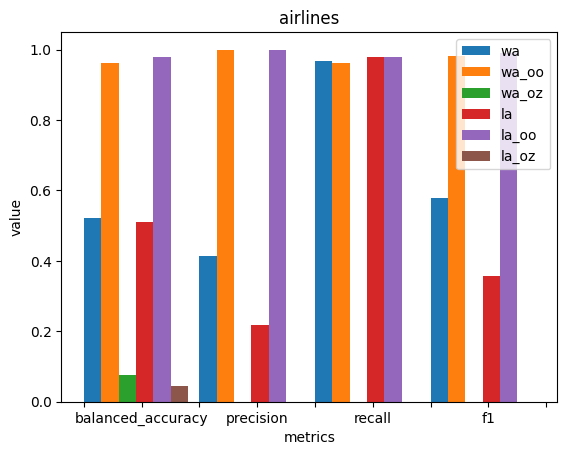

In [25]:
name="airlines"
a=evaluate_all_datasets(trainer)

### Airlines

In [26]:
name="airlines"

In [27]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Building Twitter Dataset...Dropped out 31 samples
Building Twitter Dataset...Dropped out 6 samples


In [28]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/9140 [00:00<?, ?it/s]

{'loss': 127.2934, 'learning_rate': 4.890590809628009e-06, 'epoch': 0.22}
{'loss': 65.6935, 'learning_rate': 4.781181619256018e-06, 'epoch': 0.44}
{'loss': 87.488, 'learning_rate': 4.6717724288840265e-06, 'epoch': 0.66}
{'loss': 67.8403, 'learning_rate': 4.562363238512035e-06, 'epoch': 0.88}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 30.88973045349121, 'eval_balanced_accuracy': 0.7, 'eval_precision': 0.64, 'eval_recall': 0.66, 'eval_f1': 0.65, 'eval_runtime': 2.541, 'eval_samples_per_second': 539.158, 'eval_steps_per_second': 67.69, 'epoch': 1.0}
{'loss': 40.7966, 'learning_rate': 4.452954048140044e-06, 'epoch': 1.09}
{'loss': 57.8547, 'learning_rate': 4.343544857768053e-06, 'epoch': 1.31}
{'loss': 23.9623, 'learning_rate': 4.234135667396061e-06, 'epoch': 1.53}
{'loss': 42.5664, 'learning_rate': 4.12472647702407e-06, 'epoch': 1.75}
{'loss': 12.319, 'learning_rate': 4.015317286652079e-06, 'epoch': 1.97}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 3.1997270584106445, 'eval_balanced_accuracy': 0.73, 'eval_precision': 0.65, 'eval_recall': 0.73, 'eval_f1': 0.69, 'eval_runtime': 2.54, 'eval_samples_per_second': 539.37, 'eval_steps_per_second': 67.717, 'epoch': 2.0}
{'loss': 2.1592, 'learning_rate': 3.905908096280087e-06, 'epoch': 2.19}
{'loss': 1.4801, 'learning_rate': 3.7964989059080965e-06, 'epoch': 2.41}
{'loss': 1.2803, 'learning_rate': 3.6870897155361052e-06, 'epoch': 2.63}
{'loss': 1.1941, 'learning_rate': 3.577680525164114e-06, 'epoch': 2.84}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.8152212500572205, 'eval_balanced_accuracy': 0.75, 'eval_precision': 0.67, 'eval_recall': 0.77, 'eval_f1': 0.71, 'eval_runtime': 2.536, 'eval_samples_per_second': 540.221, 'eval_steps_per_second': 67.823, 'epoch': 3.0}
{'loss': 1.161, 'learning_rate': 3.4682713347921226e-06, 'epoch': 3.06}
{'loss': 1.1217, 'learning_rate': 3.3588621444201313e-06, 'epoch': 3.28}
{'loss': 1.2022, 'learning_rate': 3.24945295404814e-06, 'epoch': 3.5}
{'loss': 1.4088, 'learning_rate': 3.1400437636761488e-06, 'epoch': 3.72}
{'loss': 1.0453, 'learning_rate': 3.0306345733041575e-06, 'epoch': 3.94}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.5306604504585266, 'eval_balanced_accuracy': 0.77, 'eval_precision': 0.65, 'eval_recall': 0.85, 'eval_f1': 0.74, 'eval_runtime': 2.512, 'eval_samples_per_second': 545.382, 'eval_steps_per_second': 68.471, 'epoch': 4.0}
{'loss': 1.3857, 'learning_rate': 2.921225382932166e-06, 'epoch': 4.16}
{'loss': 0.8578, 'learning_rate': 2.811816192560175e-06, 'epoch': 4.38}
{'loss': 1.2912, 'learning_rate': 2.7024070021881844e-06, 'epoch': 4.6}
{'loss': 1.4081, 'learning_rate': 2.592997811816193e-06, 'epoch': 4.81}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.9039907455444336, 'eval_balanced_accuracy': 0.79, 'eval_precision': 0.68, 'eval_recall': 0.85, 'eval_f1': 0.76, 'eval_runtime': 2.529, 'eval_samples_per_second': 541.716, 'eval_steps_per_second': 68.011, 'epoch': 5.0}
{'loss': 1.1771, 'learning_rate': 2.4835886214442014e-06, 'epoch': 5.03}
{'loss': 1.017, 'learning_rate': 2.37417943107221e-06, 'epoch': 5.25}
{'loss': 0.8433, 'learning_rate': 2.2647702407002188e-06, 'epoch': 5.47}
{'loss': 0.8843, 'learning_rate': 2.1553610503282275e-06, 'epoch': 5.69}
{'loss': 0.6579, 'learning_rate': 2.0459518599562366e-06, 'epoch': 5.91}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.6724916696548462, 'eval_balanced_accuracy': 0.81, 'eval_precision': 0.8, 'eval_recall': 0.74, 'eval_f1': 0.77, 'eval_runtime': 2.57, 'eval_samples_per_second': 533.074, 'eval_steps_per_second': 66.926, 'epoch': 6.0}
{'loss': 1.1278, 'learning_rate': 1.9365426695842453e-06, 'epoch': 6.13}
{'loss': 0.8202, 'learning_rate': 1.8271334792122538e-06, 'epoch': 6.35}
{'loss': 0.9531, 'learning_rate': 1.7177242888402625e-06, 'epoch': 6.56}
{'loss': 0.9924, 'learning_rate': 1.6083150984682714e-06, 'epoch': 6.78}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.44543546438217163, 'eval_balanced_accuracy': 0.82, 'eval_precision': 0.82, 'eval_recall': 0.76, 'eval_f1': 0.79, 'eval_runtime': 2.574, 'eval_samples_per_second': 532.246, 'eval_steps_per_second': 66.822, 'epoch': 7.0}
{'loss': 0.6762, 'learning_rate': 1.4989059080962803e-06, 'epoch': 7.0}
{'loss': 0.7114, 'learning_rate': 1.389496717724289e-06, 'epoch': 7.22}
{'loss': 0.9752, 'learning_rate': 1.2800875273522977e-06, 'epoch': 7.44}
{'loss': 0.6359, 'learning_rate': 1.1706783369803064e-06, 'epoch': 7.66}
{'loss': 0.8991, 'learning_rate': 1.0612691466083151e-06, 'epoch': 7.88}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.4640646278858185, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.79, 'eval_recall': 0.84, 'eval_f1': 0.82, 'eval_runtime': 2.556, 'eval_samples_per_second': 535.994, 'eval_steps_per_second': 67.293, 'epoch': 8.0}
{'loss': 0.6554, 'learning_rate': 9.518599562363239e-07, 'epoch': 8.1}
{'loss': 0.6164, 'learning_rate': 8.424507658643327e-07, 'epoch': 8.32}
{'loss': 0.7124, 'learning_rate': 7.330415754923414e-07, 'epoch': 8.53}
{'loss': 0.8283, 'learning_rate': 6.236323851203501e-07, 'epoch': 8.75}
{'loss': 0.6076, 'learning_rate': 5.14223194748359e-07, 'epoch': 8.97}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.4450599253177643, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.82, 'eval_recall': 0.83, 'eval_f1': 0.83, 'eval_runtime': 2.634, 'eval_samples_per_second': 520.122, 'eval_steps_per_second': 65.3, 'epoch': 9.0}
{'loss': 0.6923, 'learning_rate': 4.0481400437636766e-07, 'epoch': 9.19}
{'loss': 0.6701, 'learning_rate': 2.954048140043764e-07, 'epoch': 9.41}
{'loss': 0.5903, 'learning_rate': 1.8599562363238514e-07, 'epoch': 9.63}
{'loss': 0.6251, 'learning_rate': 7.658643326039388e-08, 'epoch': 9.85}


  0%|          | 0/172 [00:00<?, ?it/s]

{'eval_loss': 0.4663190245628357, 'eval_balanced_accuracy': 0.86, 'eval_precision': 0.83, 'eval_recall': 0.83, 'eval_f1': 0.83, 'eval_runtime': 2.67, 'eval_samples_per_second': 513.108, 'eval_steps_per_second': 64.419, 'epoch': 10.0}
{'train_runtime': 600.94, 'train_samples_per_second': 121.643, 'train_steps_per_second': 15.21, 'train_loss': 12.287254237502617, 'epoch': 10.0}


TrainOutput(global_step=9140, training_loss=12.287254237502617, metrics={'train_runtime': 600.94, 'train_samples_per_second': 121.643, 'train_steps_per_second': 15.21, 'train_loss': 12.287254237502617, 'epoch': 10.0})

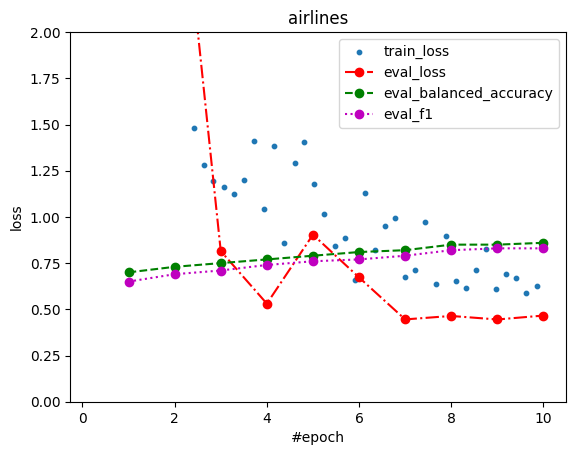

In [29]:
plot_save_results(trainer,name)

Building Twitter Dataset...Dropped out 2 samples


Testing: 100%|██████████| 46/46 [00:00<00:00, 58.38it/s]


Evaluation for dataset well_answering
Test model loss=0.13988345397123392
Balanced_accuracy: 0.8736363274406753
Precision: 0.8693181818181818
Recall: 0.8315217391304348
F1: 0.8499999999999999
Roc_auc: 0.8736363274406752
Number of ones in predictions: 176
Number of predictions: 457

Building Twitter Dataset...Dropped out 9 samples


Testing: 100%|██████████| 356/356 [00:06<00:00, 57.04it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.3242259899482188
Balanced_accuracy: 0.7956717256885891
Precision: 1.0
Recall: 0.7956717256885891
F1: 0.8862106745969635
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 2831
Number of predictions: 3558

Building Twitter Dataset...Dropped out 33 samples


Testing: 100%|██████████| 558/558 [00:10<00:00, 54.44it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.1161313234753863
Balanced_accuracy: 0.8558106169296987
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 804
Number of predictions: 5576

Building Twitter Dataset...Dropped out 58 samples


Testing: 100%|██████████| 942/942 [00:15<00:00, 61.46it/s]


Evaluation for dataset low_answering
Test model loss=0.2883600843365063
Balanced_accuracy: 0.6705706878131547
Precision: 0.34480234260614934
Recall: 0.7036852589641435
F1: 0.4628234523419587
Roc_auc: 0.6705706878131548
Number of ones in predictions: 4098
Number of predictions: 9414

Building Twitter Dataset...Dropped out 10 samples


Testing: 100%|██████████| 201/201 [00:03<00:00, 66.21it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.34522110694528213
Balanced_accuracy: 0.7036852589641435
Precision: 1.0
Recall: 0.7036852589641435
F1: 0.8260742472961122
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1413
Number of predictions: 2008

Building Twitter Dataset...Dropped out 48 samples


Testing: 100%|██████████| 741/741 [00:11<00:00, 64.50it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.26519950986699475
Balanced_accuracy: 0.6374561166621658
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 2685
Number of predictions: 7406



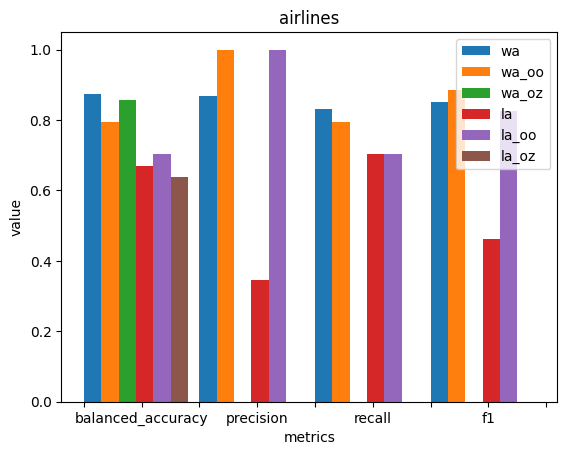

In [30]:
a=evaluate_all_datasets(trainer)

##### Generalization

In [31]:
# model=DistilBertForSequenceClassification.from_pretrained("models/well-answering-airlines/checkpoint9000")
# model=model.to(device)

Building Twitter Dataset...Dropped out 26 samples


Testing: 100%|██████████| 204/204 [00:03<00:00, 59.74it/s]


Evaluation for dataset well_answering
Test model loss=0.180163103167966
Balanced_accuracy: 0.627097156861467
Precision: 0.178117048346056
Recall: 0.4268292682926829
F1: 0.2513464991023339
Roc_auc: 0.627097156861467
Number of ones in predictions: 393
Number of predictions: 2035

Building Twitter Dataset...Dropped out 65 samples


Testing: 100%|██████████| 333/333 [00:05<00:00, 57.93it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.5330805361151575
Balanced_accuracy: 0.45109840505567256
Precision: 1.0
Recall: 0.45109840505567256
F1: 0.6217337204479468
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1499
Number of predictions: 3323

Building Twitter Dataset...Dropped out 98 samples


Testing: 100%|██████████| 991/991 [00:17<00:00, 58.11it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.13168981212469763
Balanced_accuracy: 0.8263987073318522
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1719
Number of predictions: 9902

Building Twitter Dataset...Dropped out 54 samples


Testing: 100%|██████████| 995/995 [00:18<00:00, 53.74it/s]


Evaluation for dataset low_answering
Test model loss=0.09296231231897117
Balanced_accuracy: 0.6231448091326286
Precision: 0.05989847715736041
Recall: 0.34104046242774566
F1: 0.10189982728842832
Roc_auc: 0.6231448091326286
Number of ones in predictions: 985
Number of predictions: 9946

Building Twitter Dataset...Dropped out 35 samples


Testing: 100%|██████████| 119/119 [00:02<00:00, 56.03it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.5792376674523874
Balanced_accuracy: 0.4059071729957806
Precision: 1.0
Recall: 0.4059071729957806
F1: 0.5774309723889556
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 481
Number of predictions: 1185

Building Twitter Dataset...Dropped out 84 samples


Testing: 100%|██████████| 992/992 [00:17<00:00, 56.07it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.06254304394686738
Balanced_accuracy: 0.9378781766841469
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 616
Number of predictions: 9916



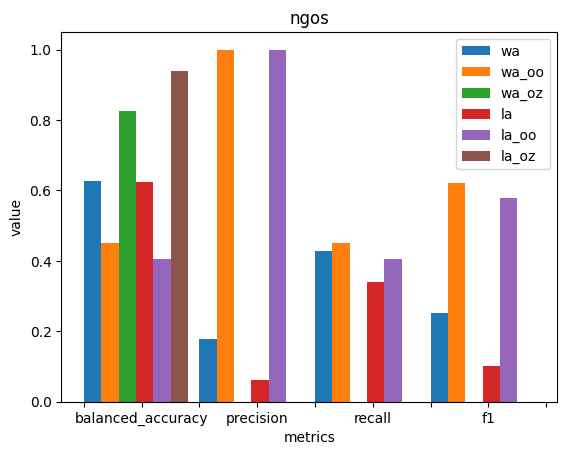

In [32]:
name="ngos"
a=evaluate_all_datasets(trainer)

Building Twitter Dataset...Dropped out 4 samples


Testing: 100%|██████████| 58/58 [00:00<00:00, 58.88it/s]


Evaluation for dataset well_answering
Test model loss=0.24240125946957483
Balanced_accuracy: 0.6347723324310128
Precision: 0.35251798561151076
Recall: 0.46226415094339623
F1: 0.39999999999999997
Roc_auc: 0.6347723324310129
Number of ones in predictions: 139
Number of predictions: 573

Building Twitter Dataset...Dropped out 12 samples


Testing: 100%|██████████| 210/210 [00:03<00:00, 54.46it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.5052048952333509
Balanced_accuracy: 0.4921090387374462
Precision: 1.0
Recall: 0.4921090387374462
F1: 0.6596153846153846
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1029
Number of predictions: 2091

Building Twitter Dataset...Dropped out 83 samples


Testing: 100%|██████████| 936/936 [00:16<00:00, 56.33it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.14419125702943197
Balanced_accuracy: 0.807141329912337
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1804
Number of predictions: 9354

Building Twitter Dataset...Dropped out 88 samples


Testing: 100%|██████████| 992/992 [00:18<00:00, 53.61it/s]


Evaluation for dataset low_answering
Test model loss=0.1284876636740182
Balanced_accuracy: 0.5711835160373528
Precision: 0.011457670273711012
Recall: 0.3
F1: 0.02207234825260576
Roc_auc: 0.5711835160373528
Number of ones in predictions: 1571
Number of predictions: 9912

Building Twitter Dataset...Dropped out 0 samples


Testing: 100%|██████████| 7/7 [00:00<00:00, 86.42it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.6668312776656377
Balanced_accuracy: 0.3114754098360656
Precision: 1.0
Recall: 0.3114754098360656
F1: 0.475
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 19
Number of predictions: 61

Building Twitter Dataset...Dropped out 90 samples


Testing: 100%|██████████| 991/991 [00:17<00:00, 56.44it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.12372273551046434
Balanced_accuracy: 0.8416750756811302
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1569
Number of predictions: 9910



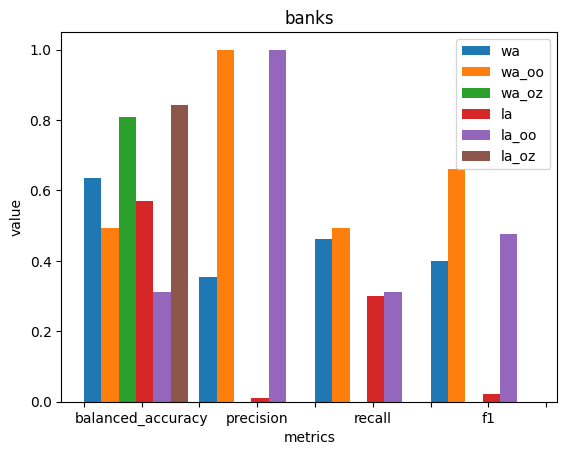

In [33]:
name="banks"
a=evaluate_all_datasets(trainer)

### ICRC

In [34]:
name="icrc"

In [35]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Building Twitter Dataset...Dropped out 216 samples
Building Twitter Dataset...Dropped out 45 samples


In [36]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/21840 [00:00<?, ?it/s]

{'loss': 122.4773, 'learning_rate': 4.954212454212455e-06, 'epoch': 0.09}
{'loss': 49.4414, 'learning_rate': 4.908424908424909e-06, 'epoch': 0.18}
{'loss': 0.6071, 'learning_rate': 4.862637362637363e-06, 'epoch': 0.27}
{'loss': 8.0714, 'learning_rate': 4.816849816849818e-06, 'epoch': 0.37}
{'loss': 64.4364, 'learning_rate': 4.771062271062271e-06, 'epoch': 0.46}
{'loss': 49.8135, 'learning_rate': 4.725274725274726e-06, 'epoch': 0.55}
{'loss': 23.0205, 'learning_rate': 4.6794871794871795e-06, 'epoch': 0.64}
{'loss': 5.33, 'learning_rate': 4.633699633699634e-06, 'epoch': 0.73}
{'loss': 17.2848, 'learning_rate': 4.587912087912088e-06, 'epoch': 0.82}
{'loss': 0.6318, 'learning_rate': 4.542124542124542e-06, 'epoch': 0.92}


  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 45.845211029052734, 'eval_balanced_accuracy': 0.66, 'eval_precision': 0.86, 'eval_recall': 0.33, 'eval_f1': 0.48, 'eval_runtime': 5.766, 'eval_samples_per_second': 567.118, 'eval_steps_per_second': 70.933, 'epoch': 1.0}
{'loss': 11.354, 'learning_rate': 4.496336996336997e-06, 'epoch': 1.01}
{'loss': 0.7333, 'learning_rate': 4.45054945054945e-06, 'epoch': 1.1}
{'loss': 80.4256, 'learning_rate': 4.404761904761905e-06, 'epoch': 1.19}
{'loss': 8.4272, 'learning_rate': 4.358974358974359e-06, 'epoch': 1.28}
{'loss': 71.4329, 'learning_rate': 4.313186813186814e-06, 'epoch': 1.37}
{'loss': 17.5419, 'learning_rate': 4.267399267399268e-06, 'epoch': 1.47}
{'loss': 5.3385, 'learning_rate': 4.221611721611722e-06, 'epoch': 1.56}
{'loss': 9.7762, 'learning_rate': 4.175824175824177e-06, 'epoch': 1.65}
{'loss': 22.6957, 'learning_rate': 4.13003663003663e-06, 'epoch': 1.74}
{'loss': 37.1638, 'learning_rate': 4.084249084249085e-06, 'epoch': 1.83}
{'loss': 7.9467, 'learning_rate': 4.03846153

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 34.84709930419922, 'eval_balanced_accuracy': 0.67, 'eval_precision': 0.89, 'eval_recall': 0.34, 'eval_f1': 0.49, 'eval_runtime': 5.786, 'eval_samples_per_second': 565.157, 'eval_steps_per_second': 70.688, 'epoch': 2.0}
{'loss': 63.5708, 'learning_rate': 3.992673992673993e-06, 'epoch': 2.01}
{'loss': 5.7983, 'learning_rate': 3.946886446886447e-06, 'epoch': 2.11}
{'loss': 32.9987, 'learning_rate': 3.901098901098901e-06, 'epoch': 2.2}
{'loss': 84.9948, 'learning_rate': 3.855311355311356e-06, 'epoch': 2.29}
{'loss': 7.4863, 'learning_rate': 3.80952380952381e-06, 'epoch': 2.38}
{'loss': 23.8286, 'learning_rate': 3.763736263736264e-06, 'epoch': 2.47}
{'loss': 23.7822, 'learning_rate': 3.7179487179487184e-06, 'epoch': 2.56}
{'loss': 39.174, 'learning_rate': 3.672161172161173e-06, 'epoch': 2.66}
{'loss': 10.3491, 'learning_rate': 3.6263736263736266e-06, 'epoch': 2.75}
{'loss': 3.3799, 'learning_rate': 3.580586080586081e-06, 'epoch': 2.84}
{'loss': 0.6611, 'learning_rate': 3.53479

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 23.35444450378418, 'eval_balanced_accuracy': 0.68, 'eval_precision': 0.96, 'eval_recall': 0.37, 'eval_f1': 0.53, 'eval_runtime': 5.765, 'eval_samples_per_second': 567.216, 'eval_steps_per_second': 70.945, 'epoch': 3.0}
{'loss': 6.5676, 'learning_rate': 3.4890109890109893e-06, 'epoch': 3.02}
{'loss': 15.0322, 'learning_rate': 3.4432234432234434e-06, 'epoch': 3.11}
{'loss': 1.7139, 'learning_rate': 3.397435897435898e-06, 'epoch': 3.21}
{'loss': 2.9969, 'learning_rate': 3.3516483516483516e-06, 'epoch': 3.3}
{'loss': 24.5909, 'learning_rate': 3.305860805860806e-06, 'epoch': 3.39}
{'loss': 5.3353, 'learning_rate': 3.2600732600732602e-06, 'epoch': 3.48}
{'loss': 34.0671, 'learning_rate': 3.2142857142857147e-06, 'epoch': 3.57}
{'loss': 15.5943, 'learning_rate': 3.1684981684981684e-06, 'epoch': 3.66}
{'loss': 3.9291, 'learning_rate': 3.122710622710623e-06, 'epoch': 3.75}
{'loss': 20.8602, 'learning_rate': 3.0769230769230774e-06, 'epoch': 3.85}
{'loss': 21.3238, 'learning_rate': 3

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 12.024331092834473, 'eval_balanced_accuracy': 0.82, 'eval_precision': 0.79, 'eval_recall': 0.66, 'eval_f1': 0.72, 'eval_runtime': 5.796, 'eval_samples_per_second': 564.179, 'eval_steps_per_second': 70.565, 'epoch': 4.0}
{'loss': 0.5398, 'learning_rate': 2.9853479853479856e-06, 'epoch': 4.03}
{'loss': 3.3319, 'learning_rate': 2.9395604395604397e-06, 'epoch': 4.12}
{'loss': 2.2826, 'learning_rate': 2.8937728937728942e-06, 'epoch': 4.21}
{'loss': 7.5734, 'learning_rate': 2.847985347985348e-06, 'epoch': 4.3}
{'loss': 2.963, 'learning_rate': 2.8021978021978024e-06, 'epoch': 4.4}
{'loss': 0.5256, 'learning_rate': 2.756410256410257e-06, 'epoch': 4.49}
{'loss': 0.9655, 'learning_rate': 2.7106227106227106e-06, 'epoch': 4.58}
{'loss': 1.7738, 'learning_rate': 2.664835164835165e-06, 'epoch': 4.67}
{'loss': 5.4202, 'learning_rate': 2.6190476190476192e-06, 'epoch': 4.76}
{'loss': 6.0375, 'learning_rate': 2.5732600732600733e-06, 'epoch': 4.85}
{'loss': 5.8561, 'learning_rate': 2.527472

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 1.4676787853240967, 'eval_balanced_accuracy': 0.86, 'eval_precision': 0.8, 'eval_recall': 0.74, 'eval_f1': 0.77, 'eval_runtime': 5.839, 'eval_samples_per_second': 560.028, 'eval_steps_per_second': 70.046, 'epoch': 5.0}
{'loss': 3.3026, 'learning_rate': 2.481684981684982e-06, 'epoch': 5.04}
{'loss': 0.5907, 'learning_rate': 2.435897435897436e-06, 'epoch': 5.13}
{'loss': 0.7818, 'learning_rate': 2.3901098901098905e-06, 'epoch': 5.22}
{'loss': 0.6901, 'learning_rate': 2.3443223443223446e-06, 'epoch': 5.31}
{'loss': 1.3011, 'learning_rate': 2.2985347985347987e-06, 'epoch': 5.4}
{'loss': 0.5763, 'learning_rate': 2.252747252747253e-06, 'epoch': 5.49}
{'loss': 0.6457, 'learning_rate': 2.206959706959707e-06, 'epoch': 5.59}
{'loss': 0.4709, 'learning_rate': 2.1611721611721614e-06, 'epoch': 5.68}
{'loss': 0.8001, 'learning_rate': 2.1153846153846155e-06, 'epoch': 5.77}
{'loss': 1.15, 'learning_rate': 2.0695970695970696e-06, 'epoch': 5.86}
{'loss': 1.007, 'learning_rate': 2.023809523

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 0.6761752963066101, 'eval_balanced_accuracy': 0.83, 'eval_precision': 0.98, 'eval_recall': 0.66, 'eval_f1': 0.79, 'eval_runtime': 5.858, 'eval_samples_per_second': 558.211, 'eval_steps_per_second': 69.819, 'epoch': 6.0}
{'loss': 1.3471, 'learning_rate': 1.9780219780219782e-06, 'epoch': 6.04}
{'loss': 0.688, 'learning_rate': 1.9322344322344323e-06, 'epoch': 6.14}
{'loss': 0.4721, 'learning_rate': 1.8864468864468866e-06, 'epoch': 6.23}
{'loss': 1.3875, 'learning_rate': 1.840659340659341e-06, 'epoch': 6.32}
{'loss': 1.7547, 'learning_rate': 1.794871794871795e-06, 'epoch': 6.41}
{'loss': 0.4905, 'learning_rate': 1.7490842490842491e-06, 'epoch': 6.5}
{'loss': 0.9164, 'learning_rate': 1.7032967032967034e-06, 'epoch': 6.59}
{'loss': 0.5184, 'learning_rate': 1.6575091575091575e-06, 'epoch': 6.68}
{'loss': 0.6126, 'learning_rate': 1.611721611721612e-06, 'epoch': 6.78}
{'loss': 0.9967, 'learning_rate': 1.5659340659340661e-06, 'epoch': 6.87}
{'loss': 0.6957, 'learning_rate': 1.52014

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 0.7811883091926575, 'eval_balanced_accuracy': 0.88, 'eval_precision': 0.93, 'eval_recall': 0.77, 'eval_f1': 0.84, 'eval_runtime': 5.864, 'eval_samples_per_second': 557.64, 'eval_steps_per_second': 69.748, 'epoch': 7.0}
{'loss': 0.3639, 'learning_rate': 1.4743589743589745e-06, 'epoch': 7.05}
{'loss': 1.1511, 'learning_rate': 1.4285714285714286e-06, 'epoch': 7.14}
{'loss': 0.3927, 'learning_rate': 1.382783882783883e-06, 'epoch': 7.23}
{'loss': 1.8388, 'learning_rate': 1.336996336996337e-06, 'epoch': 7.33}
{'loss': 0.4529, 'learning_rate': 1.2912087912087915e-06, 'epoch': 7.42}
{'loss': 0.4264, 'learning_rate': 1.2454212454212456e-06, 'epoch': 7.51}
{'loss': 0.3708, 'learning_rate': 1.1996336996336997e-06, 'epoch': 7.6}
{'loss': 0.6894, 'learning_rate': 1.153846153846154e-06, 'epoch': 7.69}
{'loss': 0.4913, 'learning_rate': 1.1080586080586081e-06, 'epoch': 7.78}
{'loss': 0.5183, 'learning_rate': 1.0622710622710622e-06, 'epoch': 7.88}
{'loss': 1.1062, 'learning_rate': 1.01648

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 0.5858271718025208, 'eval_balanced_accuracy': 0.89, 'eval_precision': 0.96, 'eval_recall': 0.78, 'eval_f1': 0.86, 'eval_runtime': 5.891, 'eval_samples_per_second': 555.084, 'eval_steps_per_second': 69.428, 'epoch': 8.0}
{'loss': 0.4464, 'learning_rate': 9.706959706959708e-07, 'epoch': 8.06}
{'loss': 1.1321, 'learning_rate': 9.24908424908425e-07, 'epoch': 8.15}
{'loss': 0.9864, 'learning_rate': 8.791208791208792e-07, 'epoch': 8.24}
{'loss': 0.478, 'learning_rate': 8.333333333333333e-07, 'epoch': 8.33}
{'loss': 0.5767, 'learning_rate': 7.875457875457876e-07, 'epoch': 8.42}
{'loss': 0.9921, 'learning_rate': 7.417582417582418e-07, 'epoch': 8.52}
{'loss': 0.3777, 'learning_rate': 6.95970695970696e-07, 'epoch': 8.61}
{'loss': 0.3848, 'learning_rate': 6.501831501831502e-07, 'epoch': 8.7}
{'loss': 0.7407, 'learning_rate': 6.043956043956044e-07, 'epoch': 8.79}
{'loss': 0.6456, 'learning_rate': 5.586080586080586e-07, 'epoch': 8.88}
{'loss': 0.4816, 'learning_rate': 5.12820512820512

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 0.7882546782493591, 'eval_balanced_accuracy': 0.9, 'eval_precision': 0.97, 'eval_recall': 0.8, 'eval_f1': 0.88, 'eval_runtime': 5.908, 'eval_samples_per_second': 553.487, 'eval_steps_per_second': 69.228, 'epoch': 9.0}
{'loss': 0.6295, 'learning_rate': 4.670329670329671e-07, 'epoch': 9.07}
{'loss': 0.5307, 'learning_rate': 4.212454212454213e-07, 'epoch': 9.16}
{'loss': 2.2981, 'learning_rate': 3.754578754578755e-07, 'epoch': 9.25}
{'loss': 0.6644, 'learning_rate': 3.296703296703297e-07, 'epoch': 9.34}
{'loss': 0.6916, 'learning_rate': 2.838827838827839e-07, 'epoch': 9.43}
{'loss': 0.512, 'learning_rate': 2.3809523809523811e-07, 'epoch': 9.52}
{'loss': 0.3328, 'learning_rate': 1.9230769230769234e-07, 'epoch': 9.62}
{'loss': 0.3453, 'learning_rate': 1.4652014652014654e-07, 'epoch': 9.71}
{'loss': 0.3585, 'learning_rate': 1.0073260073260075e-07, 'epoch': 9.8}
{'loss': 0.4645, 'learning_rate': 5.494505494505495e-08, 'epoch': 9.89}
{'loss': 0.3105, 'learning_rate': 9.1575091575

  0%|          | 0/409 [00:00<?, ?it/s]

{'eval_loss': 0.6361491084098816, 'eval_balanced_accuracy': 0.91, 'eval_precision': 0.97, 'eval_recall': 0.81, 'eval_f1': 0.89, 'eval_runtime': 5.953, 'eval_samples_per_second': 549.303, 'eval_steps_per_second': 68.705, 'epoch': 10.0}
{'train_runtime': 1397.8839, 'train_samples_per_second': 124.946, 'train_steps_per_second': 15.624, 'train_loss': 10.464081988622855, 'epoch': 10.0}


TrainOutput(global_step=21840, training_loss=10.464081988622855, metrics={'train_runtime': 1397.8839, 'train_samples_per_second': 124.946, 'train_steps_per_second': 15.624, 'train_loss': 10.464081988622855, 'epoch': 10.0})

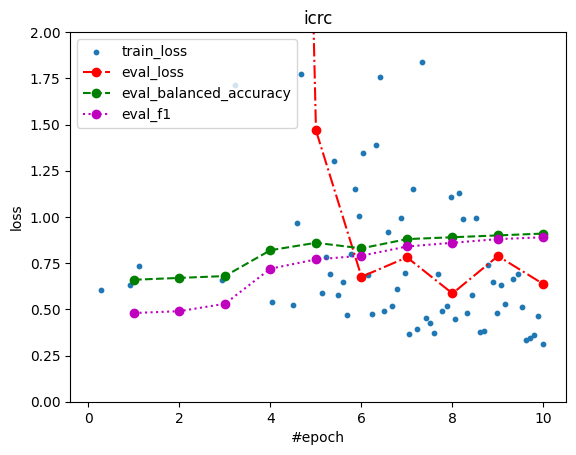

In [37]:
plot_save_results(trainer,name)

Building Twitter Dataset...Dropped out 19 samples


Testing: 100%|██████████| 109/109 [00:01<00:00, 58.04it/s]


Evaluation for dataset well_answering
Test model loss=0.09219170261291208
Balanced_accuracy: 0.9265326925877384
Precision: 0.9574468085106383
Recall: 0.8571428571428571
F1: 0.9045226130653266
Roc_auc: 0.9265326925877385
Number of ones in predictions: 94
Number of predictions: 1086

Building Twitter Dataset...Dropped out 62 samples


Testing: 100%|██████████| 212/212 [00:03<00:00, 55.21it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.6186041415027643
Balanced_accuracy: 0.7431539187913125
Precision: 1.0
Recall: 0.7431539187913125
F1: 0.8526543878656555
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 1574
Number of predictions: 2118

Building Twitter Dataset...Dropped out 117 samples


Testing: 100%|██████████| 989/989 [00:17<00:00, 57.18it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.014929613589274943
Balanced_accuracy: 0.9910958211069514
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 88
Number of predictions: 9883

Building Twitter Dataset...Dropped out 91 samples


Testing: 100%|██████████| 991/991 [00:19<00:00, 50.69it/s]


Evaluation for dataset low_answering
Test model loss=0.2740567227790437
Balanced_accuracy: 0.7309047369368382
Precision: 0.14093959731543623
Recall: 0.5547169811320755
F1: 0.22477064220183485
Roc_auc: 0.7309047369368383
Number of ones in predictions: 1043
Number of predictions: 9909

Building Twitter Dataset...Dropped out 38 samples


Testing: 100%|██████████| 127/127 [00:02<00:00, 53.79it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=1.2452733875313418
Balanced_accuracy: 0.5322834645669291
Precision: 1.0
Recall: 0.5322834645669291
F1: 0.6947584789311408
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 676
Number of predictions: 1270

Building Twitter Dataset...Dropped out 84 samples


Testing: 100%|██████████| 992/992 [00:18<00:00, 54.44it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.036377893208375284
Balanced_accuracy: 0.977511093182735
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 223
Number of predictions: 9916



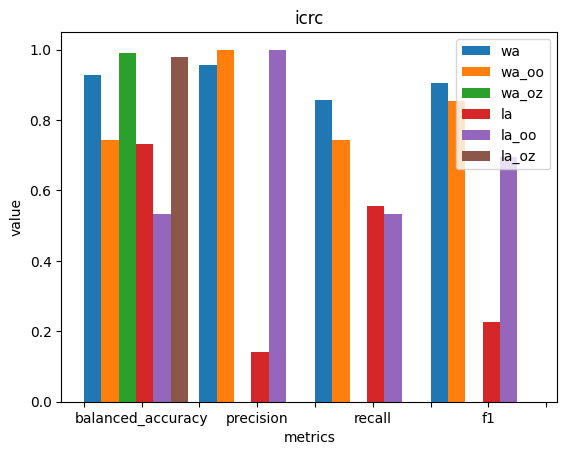

In [38]:
a=evaluate_all_datasets(trainer)

### Other NGOs

In [39]:
name="other_ngo"

In [40]:
trainer=training(name,10)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Building Twitter Dataset...Dropped out 14 samples
Building Twitter Dataset...Dropped out 2 samples


In [41]:
trainer.train()

c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\transformers\optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/13490 [00:00<?, ?it/s]

{'loss': 50.6408, 'learning_rate': 4.925871015567087e-06, 'epoch': 0.15}
{'loss': 5.2407, 'learning_rate': 4.851742031134174e-06, 'epoch': 0.3}
{'loss': 4.6244, 'learning_rate': 4.77761304670126e-06, 'epoch': 0.44}
{'loss': 0.8885, 'learning_rate': 4.703484062268348e-06, 'epoch': 0.59}
{'loss': 1.3383, 'learning_rate': 4.629355077835434e-06, 'epoch': 0.74}
{'loss': 13.2697, 'learning_rate': 4.555226093402521e-06, 'epoch': 0.89}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 1.9955247640609741, 'eval_balanced_accuracy': 0.64, 'eval_precision': 0.89, 'eval_recall': 0.28, 'eval_f1': 0.42, 'eval_runtime': 3.6432, 'eval_samples_per_second': 555.558, 'eval_steps_per_second': 69.445, 'epoch': 1.0}
{'loss': 3.235, 'learning_rate': 4.481097108969607e-06, 'epoch': 1.04}
{'loss': 4.3322, 'learning_rate': 4.406968124536694e-06, 'epoch': 1.19}
{'loss': 2.4085, 'learning_rate': 4.332839140103781e-06, 'epoch': 1.33}
{'loss': 1.7706, 'learning_rate': 4.258710155670868e-06, 'epoch': 1.48}
{'loss': 1.5138, 'learning_rate': 4.1845811712379545e-06, 'epoch': 1.63}
{'loss': 0.7269, 'learning_rate': 4.110452186805041e-06, 'epoch': 1.78}
{'loss': 0.7101, 'learning_rate': 4.036323202372128e-06, 'epoch': 1.93}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 2.888314723968506, 'eval_balanced_accuracy': 0.64, 'eval_precision': 0.95, 'eval_recall': 0.29, 'eval_f1': 0.44, 'eval_runtime': 3.651, 'eval_samples_per_second': 554.369, 'eval_steps_per_second': 69.296, 'epoch': 2.0}
{'loss': 1.1198, 'learning_rate': 3.962194217939215e-06, 'epoch': 2.08}
{'loss': 5.3686, 'learning_rate': 3.888065233506301e-06, 'epoch': 2.22}
{'loss': 2.2815, 'learning_rate': 3.813936249073388e-06, 'epoch': 2.37}
{'loss': 1.1758, 'learning_rate': 3.739807264640475e-06, 'epoch': 2.52}
{'loss': 0.6484, 'learning_rate': 3.6656782802075615e-06, 'epoch': 2.67}
{'loss': 0.6494, 'learning_rate': 3.5915492957746485e-06, 'epoch': 2.82}
{'loss': 3.0916, 'learning_rate': 3.517420311341735e-06, 'epoch': 2.97}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 1.2683442831039429, 'eval_balanced_accuracy': 0.7, 'eval_precision': 0.82, 'eval_recall': 0.41, 'eval_f1': 0.54, 'eval_runtime': 3.633, 'eval_samples_per_second': 557.115, 'eval_steps_per_second': 69.639, 'epoch': 3.0}
{'loss': 1.4986, 'learning_rate': 3.4432913269088213e-06, 'epoch': 3.11}
{'loss': 0.9772, 'learning_rate': 3.3691623424759083e-06, 'epoch': 3.26}
{'loss': 1.283, 'learning_rate': 3.295033358042995e-06, 'epoch': 3.41}
{'loss': 1.7113, 'learning_rate': 3.220904373610082e-06, 'epoch': 3.56}
{'loss': 1.3176, 'learning_rate': 3.1467753891771684e-06, 'epoch': 3.71}
{'loss': 0.7525, 'learning_rate': 3.072646404744255e-06, 'epoch': 3.85}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 0.7339244484901428, 'eval_balanced_accuracy': 0.69, 'eval_precision': 1.0, 'eval_recall': 0.38, 'eval_f1': 0.55, 'eval_runtime': 3.6375, 'eval_samples_per_second': 556.425, 'eval_steps_per_second': 69.553, 'epoch': 4.0}
{'loss': 1.1335, 'learning_rate': 2.998517420311342e-06, 'epoch': 4.0}
{'loss': 0.7489, 'learning_rate': 2.9243884358784286e-06, 'epoch': 4.15}
{'loss': 1.0605, 'learning_rate': 2.8502594514455156e-06, 'epoch': 4.3}
{'loss': 2.1851, 'learning_rate': 2.7761304670126022e-06, 'epoch': 4.45}
{'loss': 1.0941, 'learning_rate': 2.702001482579689e-06, 'epoch': 4.6}
{'loss': 1.1369, 'learning_rate': 2.627872498146776e-06, 'epoch': 4.74}
{'loss': 3.2358, 'learning_rate': 2.5537435137138624e-06, 'epoch': 4.89}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 0.6224941611289978, 'eval_balanced_accuracy': 0.77, 'eval_precision': 0.89, 'eval_recall': 0.54, 'eval_f1': 0.67, 'eval_runtime': 3.6949, 'eval_samples_per_second': 547.779, 'eval_steps_per_second': 68.472, 'epoch': 5.0}
{'loss': 0.8315, 'learning_rate': 2.479614529280949e-06, 'epoch': 5.04}
{'loss': 2.0693, 'learning_rate': 2.4054855448480356e-06, 'epoch': 5.19}
{'loss': 0.6481, 'learning_rate': 2.3313565604151226e-06, 'epoch': 5.34}
{'loss': 0.7279, 'learning_rate': 2.257227575982209e-06, 'epoch': 5.49}
{'loss': 0.7234, 'learning_rate': 2.1830985915492958e-06, 'epoch': 5.63}
{'loss': 1.6169, 'learning_rate': 2.1089696071163828e-06, 'epoch': 5.78}
{'loss': 0.9657, 'learning_rate': 2.0348406226834694e-06, 'epoch': 5.93}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 0.9141387939453125, 'eval_balanced_accuracy': 0.78, 'eval_precision': 0.96, 'eval_recall': 0.56, 'eval_f1': 0.71, 'eval_runtime': 3.635, 'eval_samples_per_second': 556.809, 'eval_steps_per_second': 69.601, 'epoch': 6.0}
{'loss': 0.9708, 'learning_rate': 1.9607116382505564e-06, 'epoch': 6.08}
{'loss': 1.0509, 'learning_rate': 1.886582653817643e-06, 'epoch': 6.23}
{'loss': 1.4683, 'learning_rate': 1.8124536693847295e-06, 'epoch': 6.38}
{'loss': 0.7234, 'learning_rate': 1.7383246849518161e-06, 'epoch': 6.52}
{'loss': 0.5986, 'learning_rate': 1.664195700518903e-06, 'epoch': 6.67}
{'loss': 1.005, 'learning_rate': 1.5900667160859897e-06, 'epoch': 6.82}
{'loss': 0.8471, 'learning_rate': 1.5159377316530765e-06, 'epoch': 6.97}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 1.0090954303741455, 'eval_balanced_accuracy': 0.85, 'eval_precision': 0.89, 'eval_recall': 0.7, 'eval_f1': 0.79, 'eval_runtime': 3.593, 'eval_samples_per_second': 563.317, 'eval_steps_per_second': 70.415, 'epoch': 7.0}
{'loss': 0.7495, 'learning_rate': 1.441808747220163e-06, 'epoch': 7.12}
{'loss': 0.9961, 'learning_rate': 1.36767976278725e-06, 'epoch': 7.26}
{'loss': 0.7752, 'learning_rate': 1.2935507783543367e-06, 'epoch': 7.41}
{'loss': 0.642, 'learning_rate': 1.2194217939214235e-06, 'epoch': 7.56}
{'loss': 0.4658, 'learning_rate': 1.14529280948851e-06, 'epoch': 7.71}
{'loss': 1.1255, 'learning_rate': 1.0711638250555969e-06, 'epoch': 7.86}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 0.43802350759506226, 'eval_balanced_accuracy': 0.87, 'eval_precision': 0.96, 'eval_recall': 0.74, 'eval_f1': 0.83, 'eval_runtime': 3.701, 'eval_samples_per_second': 546.879, 'eval_steps_per_second': 68.36, 'epoch': 8.0}
{'loss': 1.9888, 'learning_rate': 9.970348406226837e-07, 'epoch': 8.01}
{'loss': 0.8538, 'learning_rate': 9.229058561897703e-07, 'epoch': 8.15}
{'loss': 0.6815, 'learning_rate': 8.487768717568571e-07, 'epoch': 8.3}
{'loss': 0.5166, 'learning_rate': 7.746478873239437e-07, 'epoch': 8.45}
{'loss': 0.7762, 'learning_rate': 7.005189028910304e-07, 'epoch': 8.6}
{'loss': 0.514, 'learning_rate': 6.263899184581172e-07, 'epoch': 8.75}
{'loss': 0.5339, 'learning_rate': 5.522609340252038e-07, 'epoch': 8.9}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 0.487823486328125, 'eval_balanced_accuracy': 0.88, 'eval_precision': 0.92, 'eval_recall': 0.77, 'eval_f1': 0.84, 'eval_runtime': 3.638, 'eval_samples_per_second': 556.349, 'eval_steps_per_second': 69.544, 'epoch': 9.0}
{'loss': 0.8548, 'learning_rate': 4.781319495922906e-07, 'epoch': 9.04}
{'loss': 0.7777, 'learning_rate': 4.040029651593774e-07, 'epoch': 9.19}
{'loss': 1.3112, 'learning_rate': 3.2987398072646407e-07, 'epoch': 9.34}
{'loss': 0.8664, 'learning_rate': 2.557449962935508e-07, 'epoch': 9.49}
{'loss': 0.6058, 'learning_rate': 1.8161601186063753e-07, 'epoch': 9.64}
{'loss': 0.344, 'learning_rate': 1.0748702742772425e-07, 'epoch': 9.79}
{'loss': 0.4966, 'learning_rate': 3.3358042994810974e-08, 'epoch': 9.93}


  0%|          | 0/253 [00:00<?, ?it/s]

{'eval_loss': 0.40800711512565613, 'eval_balanced_accuracy': 0.88, 'eval_precision': 0.95, 'eval_recall': 0.77, 'eval_f1': 0.85, 'eval_runtime': 3.72, 'eval_samples_per_second': 544.086, 'eval_steps_per_second': 68.011, 'epoch': 10.0}
{'train_runtime': 851.4516, 'train_samples_per_second': 126.737, 'train_steps_per_second': 15.844, 'train_loss': 2.2759132116613254, 'epoch': 10.0}


TrainOutput(global_step=13490, training_loss=2.2759132116613254, metrics={'train_runtime': 851.4516, 'train_samples_per_second': 126.737, 'train_steps_per_second': 15.844, 'train_loss': 2.2759132116613254, 'epoch': 10.0})

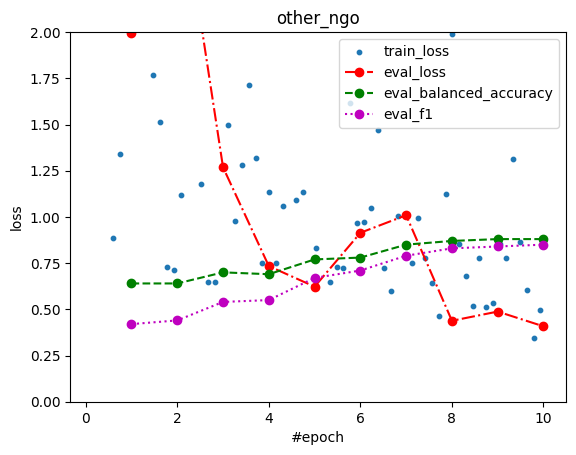

In [42]:
plot_save_results(trainer,name)

Building Twitter Dataset...Dropped out 1 samples


Testing: 100%|██████████| 68/68 [00:01<00:00, 58.93it/s]


Evaluation for dataset well_answering
Test model loss=0.1921585758237223
Balanced_accuracy: 0.8571032954860149
Precision: 0.9428571428571428
Recall: 0.717391304347826
F1: 0.8148148148148148
Roc_auc: 0.857103295486015
Number of ones in predictions: 35
Number of predictions: 674

Building Twitter Dataset...Dropped out 0 samples


Testing: 100%|██████████| 92/92 [00:01<00:00, 49.33it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset well_answering only ones
Test model loss=0.5774736751167887
Balanced_accuracy: 0.7088331515812432
Precision: 1.0
Recall: 0.7088331515812432
F1: 0.8296107211231653
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 650
Number of predictions: 917

Building Twitter Dataset...Dropped out 17 samples


Testing: 100%|██████████| 999/999 [00:17<00:00, 58.71it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation for dataset well_answering only zeros
Test model loss=0.012530643626832202
Balanced_accuracy: 0.991185014524692
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 88
Number of predictions: 9983

Building Twitter Dataset...Dropped out 21 samples


Testing: 100%|██████████| 998/998 [00:18<00:00, 55.24it/s]


Evaluation for dataset low_answering
Test model loss=1.3464788821791536
Balanced_accuracy: 0.6046988110384768
Precision: 0.008835341365461847
Recall: 0.9565217391304348
F1: 0.017508953442101075
Roc_auc: 0.6046988110384768
Number of ones in predictions: 7470
Number of predictions: 9979

Building Twitter Dataset...Dropped out 0 samples


Testing: 100%|██████████| 21/21 [00:00<00:00, 59.50it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluation for dataset low_answering only ones
Test model loss=0.05977905271500941
Balanced_accuracy: 0.9509803921568627
Precision: 1.0
Recall: 0.9509803921568627
F1: 0.9748743718592965
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 194
Number of predictions: 204

Building Twitter Dataset...Dropped out 22 samples


Testing: 100%|██████████| 998/998 [00:15<00:00, 65.91it/s]
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\modern_nlp\lib\site-packages\ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


Evaluation for dataset low_answering only zeros
Test model loss=0.79724808670924
Balanced_accuracy: 0.575265584285428
Precision: 0.0
Recall: 0.0
F1: 0.0
Impossible to define ROC_AUC - only one class presents!
Number of ones in predictions: 4238
Number of predictions: 9978



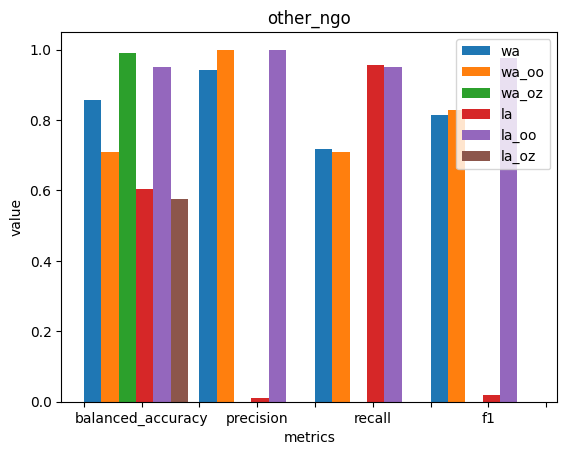

In [43]:
a=evaluate_all_datasets(trainer)